In [71]:
import pixeltable as pxt

table = pxt.get_table("poc.data")
# table.show()

/home/razvantalexandru/Documents/Projects/NeuralBits/multimodal-agents-course/ingestion/.venv/lib/python3.12/site-packages/pixeltable/catalog/table_version.py:449: PixeltableWarning: The computed column 'video_caption' in table 'data' is no longer valid.
The UDF 'core.functions.caption_video' cannot be located, because
the symbol 'core.functions.caption_video' is no longer a UDF. (Was the `@pxt.udf` decorator removed?)
You can continue to query existing data from this column, but evaluating it on new data will raise an error.
  _ = col.value_expr
/home/razvantalexandru/Documents/Projects/NeuralBits/multimodal-agents-course/ingestion/.venv/lib/python3.12/site-packages/pixeltable/catalog/table_version.py:449: PixeltableWarning: The computed column 'fulltext' in table 'data' is no longer valid.
The UDF 'core.functions.compose_semantics' cannot be located, because
the symbol 'core.functions.compose_semantics' is no longer a UDF. (Was the `@pxt.udf` decorator removed?)
You can continue to q

In [72]:
print(table.list_views())
frames = pxt.get_table("poc.frames")
print(frames.columns)

['poc.sentences', 'frames']


Error: Path 'poc.frames' does not exist.

pos_msec,frame
0.,
1000.,

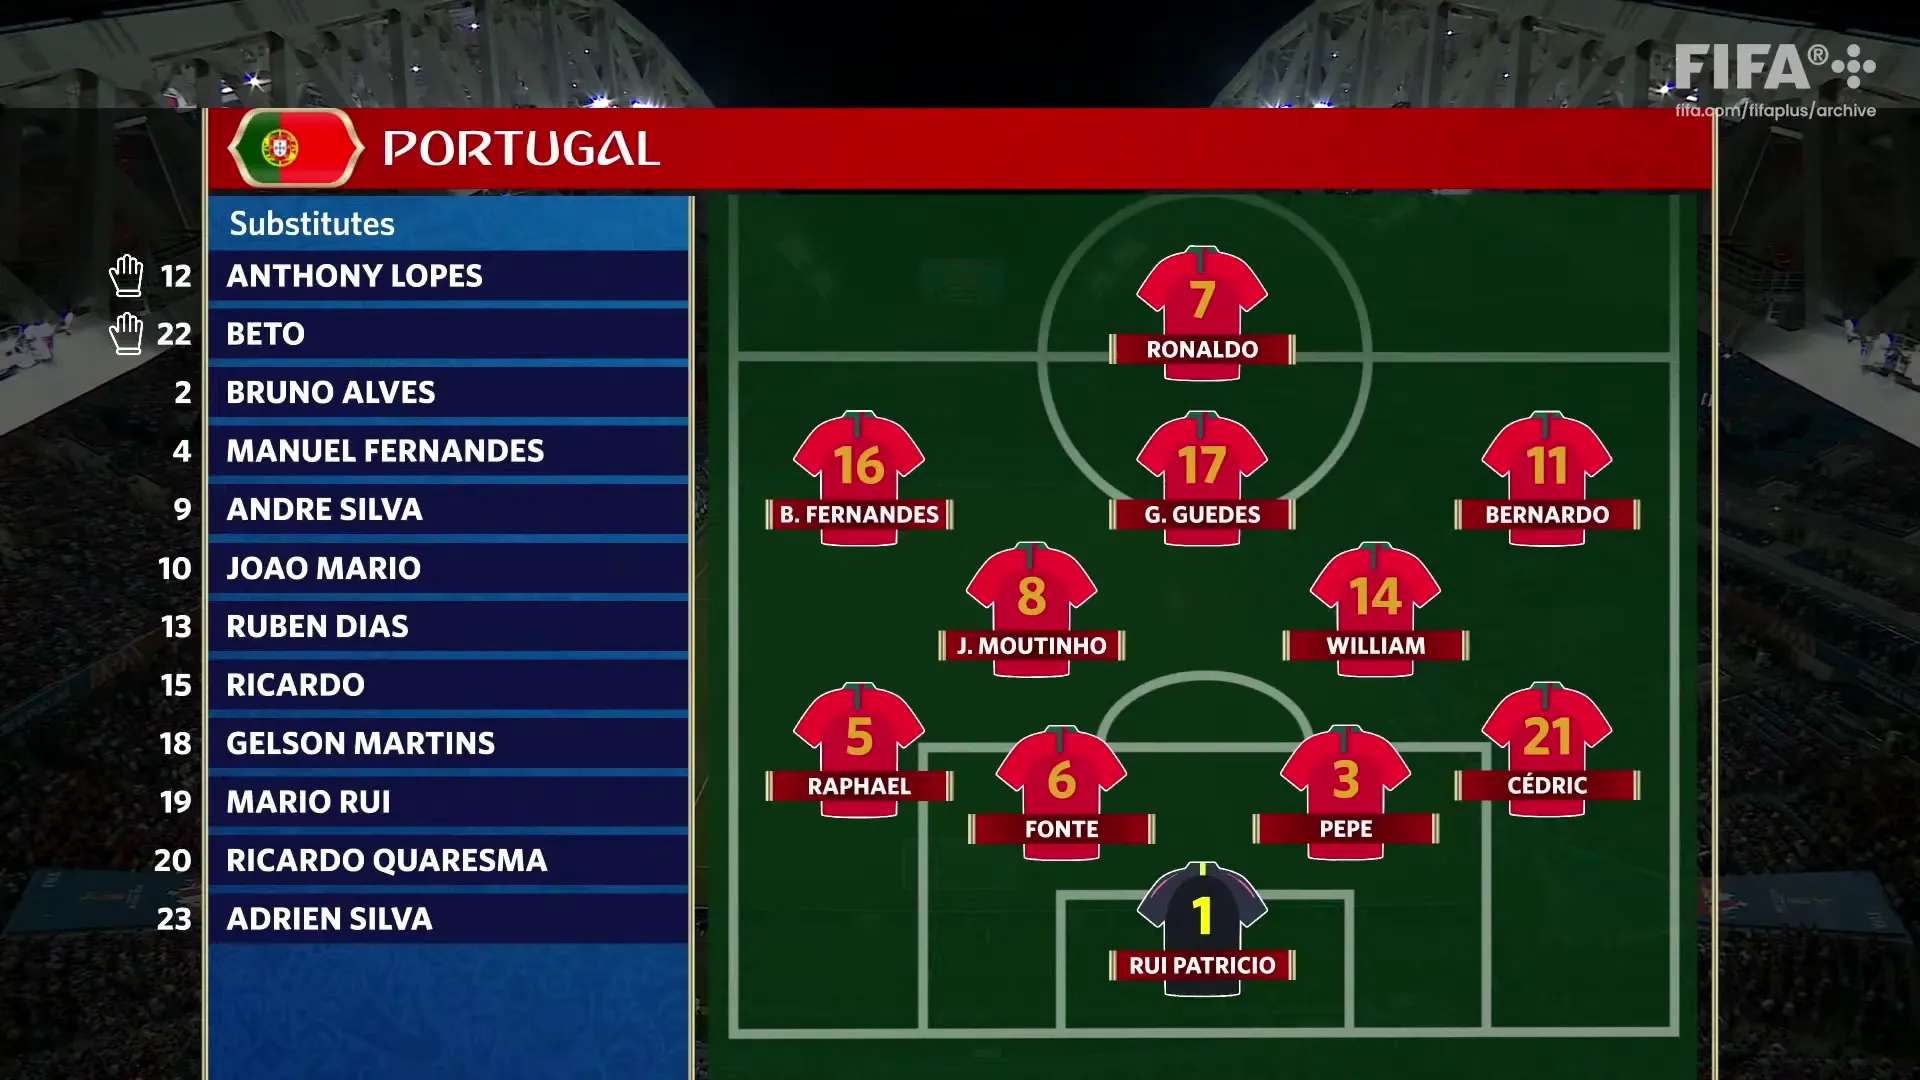
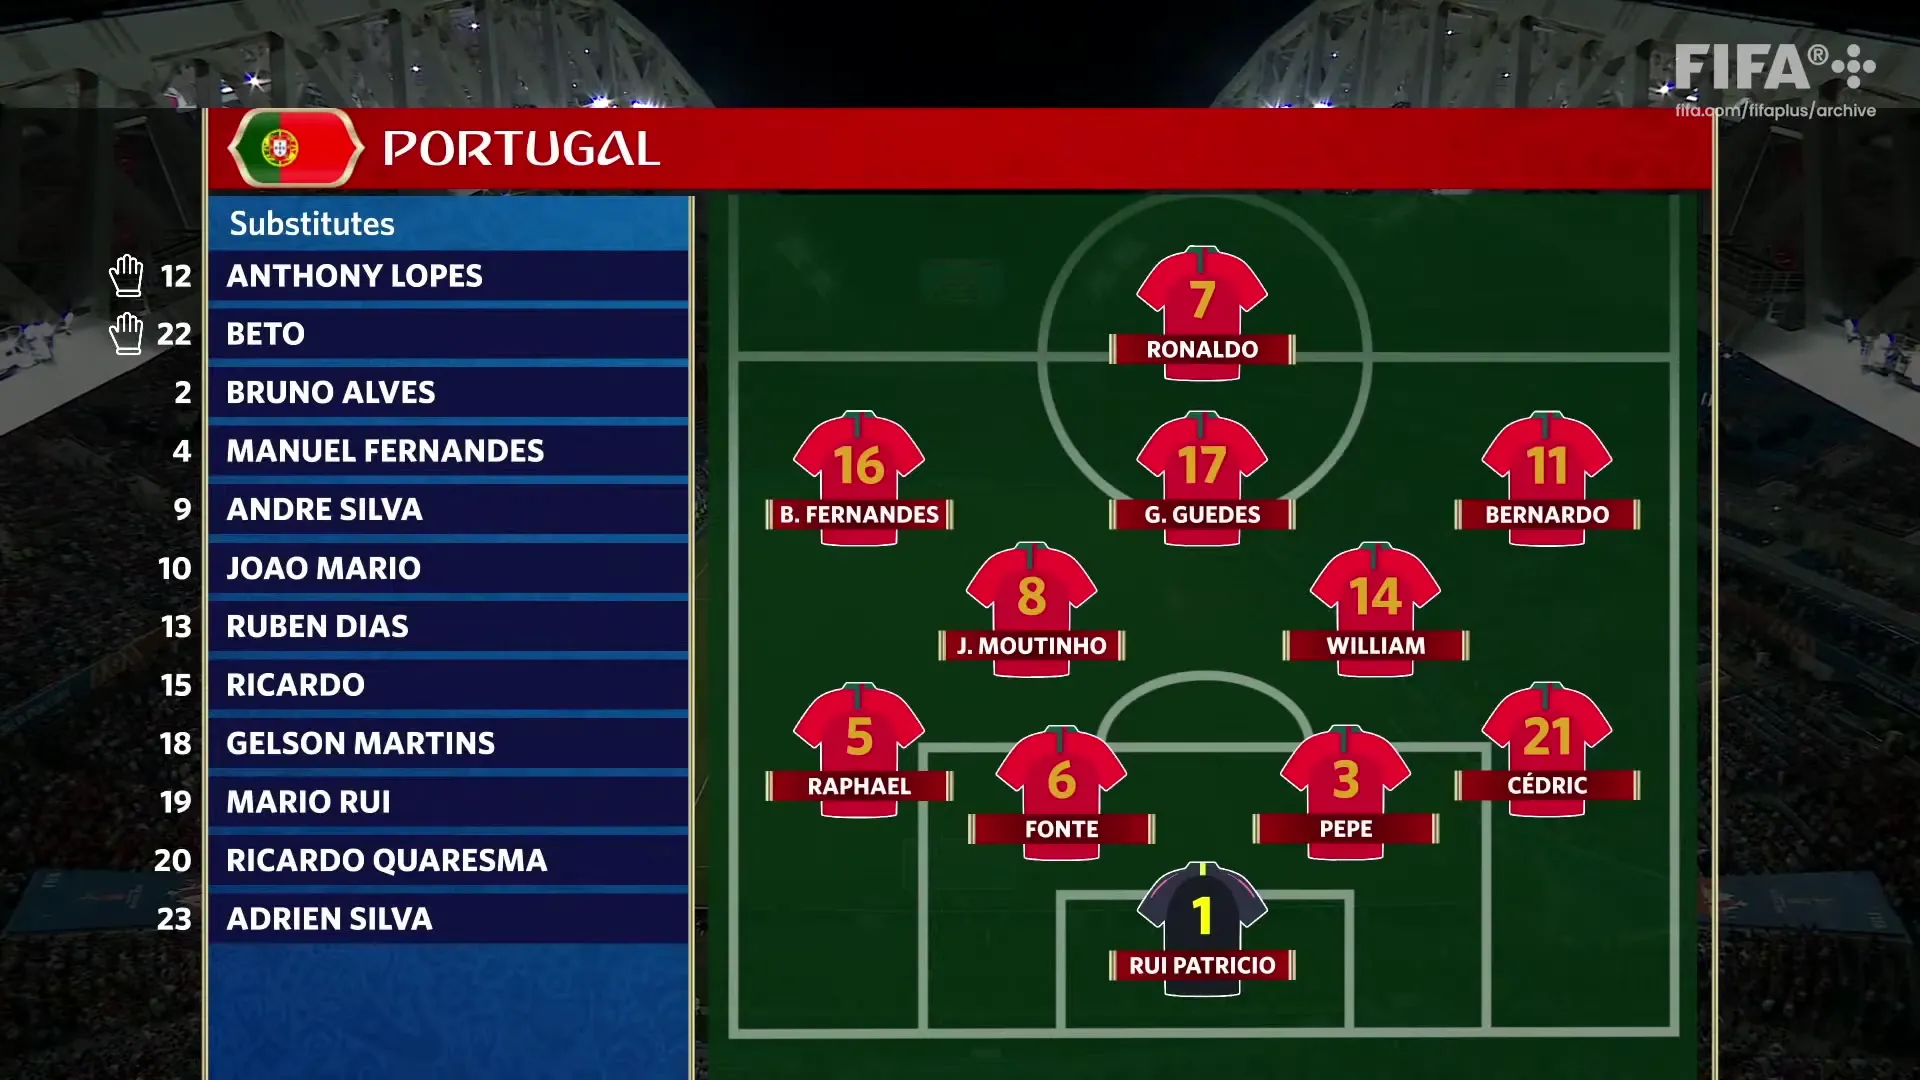

In [ ]:
frames.select(frames.pos_msec, frames.frame).show(2)

In [ ]:
# create udf that gets frame_pos, frame_posmsec, transcripts
# groups these two into by extracting transcript text only at that frame_pos + fps
# [frame_pos - 1sec, frame_pos + 1sec] interval
@pxt.udf
def group_sentence_by_frames(
    frame_pos_msec: pxt.type_system.Float, transcript: pxt.type_system.Json
) -> pxt.type_system.String:
    relevant_text = ""
    frame_start_time = frame_pos_msec / 1e3
    frame_end_time = frame_pos_msec / 1e3 + 1

    for segment in transcript["segments"]:
        segment_start = segment["start"]
        segment_end = segment["end"]

        if segment_start < frame_end_time and segment_end > frame_start_time:
            relevant_text += segment["text"] + " "

    return relevant_text.strip()


frames.add_computed_column(
    sentence_by_frame=group_sentence_by_frames(frame_pos_msec=frames.pos_msec, transcript=frames.transcription),
    if_exists="replace",
)

Added 52 column values with 0 errors.


UpdateStatus(num_rows=52, num_computed_values=52, num_excs=0, updated_cols=[], cols_with_excs=[])

In [ ]:
frames.select(frames.sentence_by_frame, frames.frame, frames.transcription.text).show(10)

In [ ]:
from pixeltable.functions.huggingface import sentence_transformer

frames.add_embedding_index(
    column=frames.sentence_by_frame,
    string_embed=sentence_transformer.using(model_id="intfloat/e5-large-v2"),
    if_exists="replace",
)


In [ ]:
sim = frames.sentence_by_frame.similarity("Cristiano Ronaldo")
(frames.order_by(sim, asc=False).limit(10).select(frames.sentence_by_frame, frames.frame, similarity=sim).collect())

frame,sentence_by_frame
,"charge. To Italian assistance, Ra'Yusi Sato from Japan is the fourth official. And back"
,"charge. To Italian assistance, Ra'Yusi Sato from Japan is the fourth official. And back"
,"charge. To Italian assistance, Ra'Yusi Sato from Japan is the fourth official. And back"
,"charge. To Italian assistance, Ra'Yusi Sato from Japan is the fourth official. And back"
,"charge. To Italian assistance, Ra'Yusi Sato from Japan is the fourth official. And back"

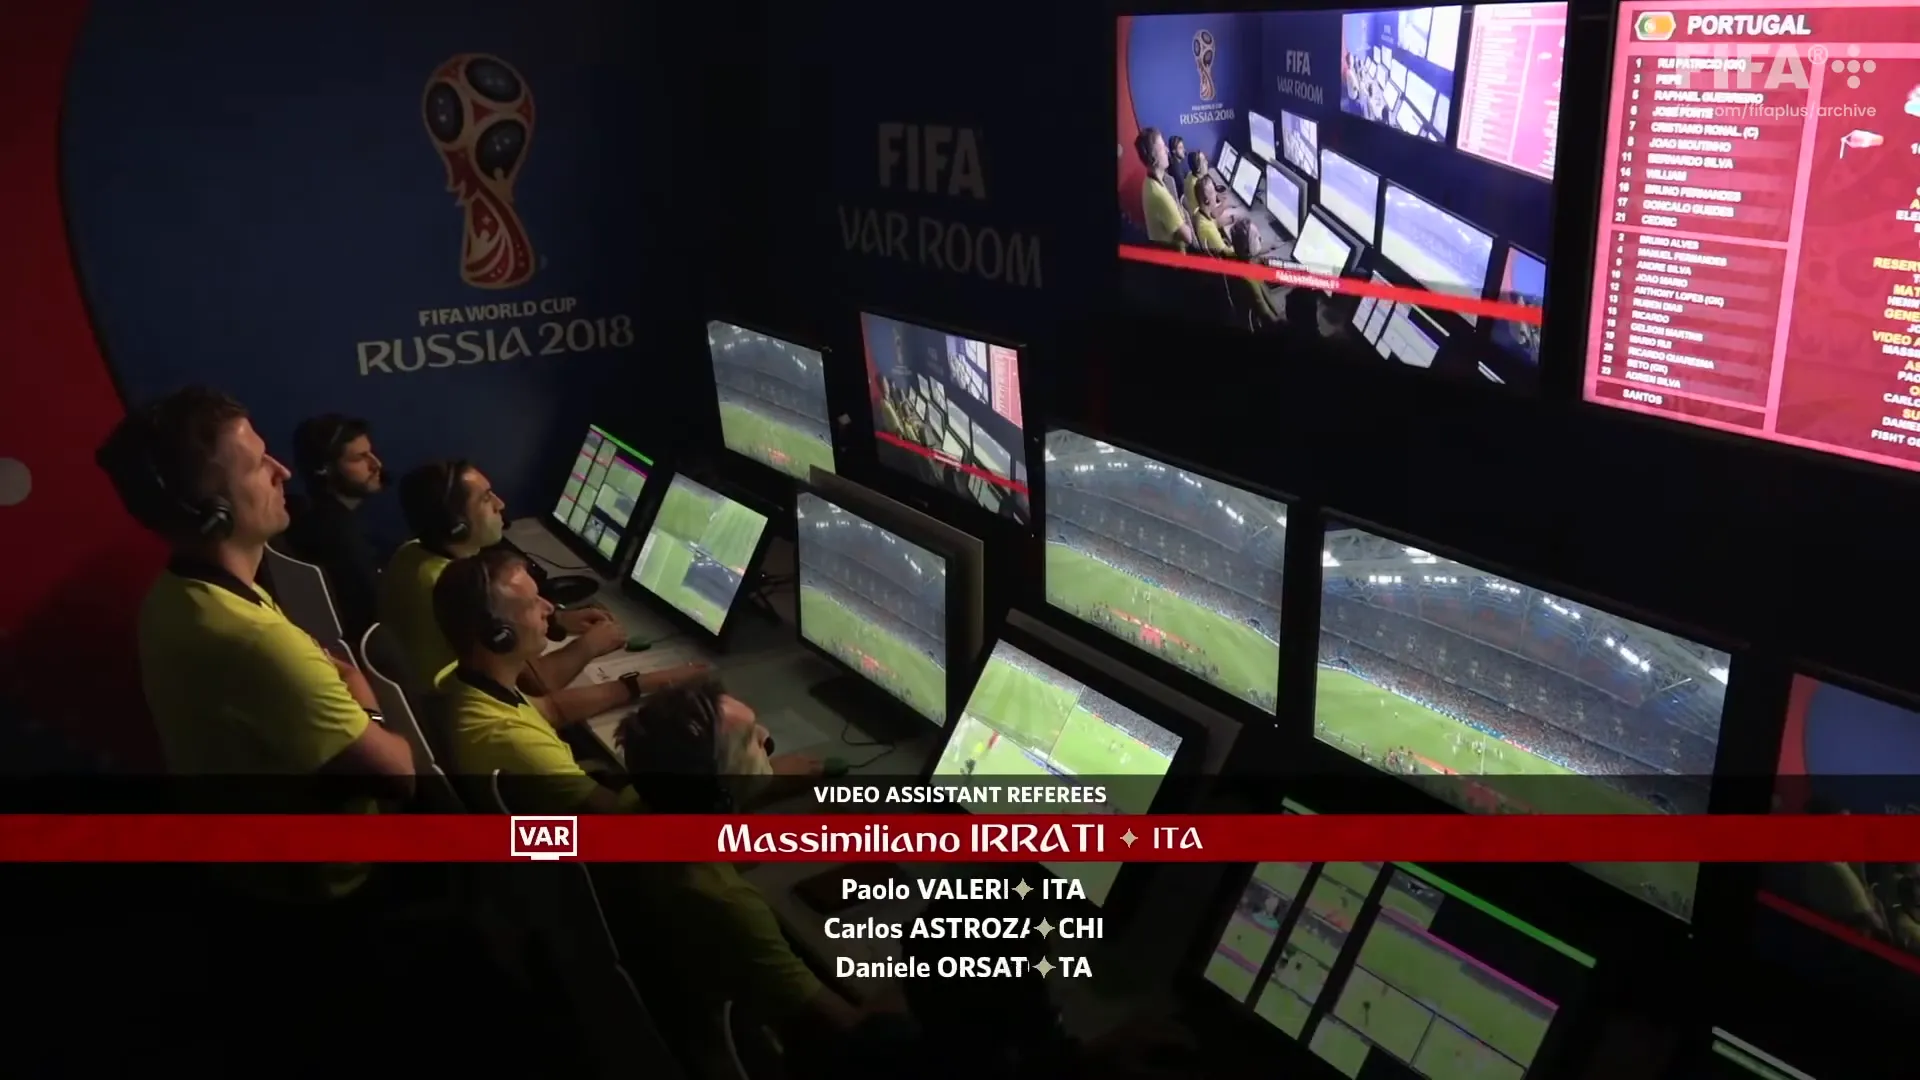
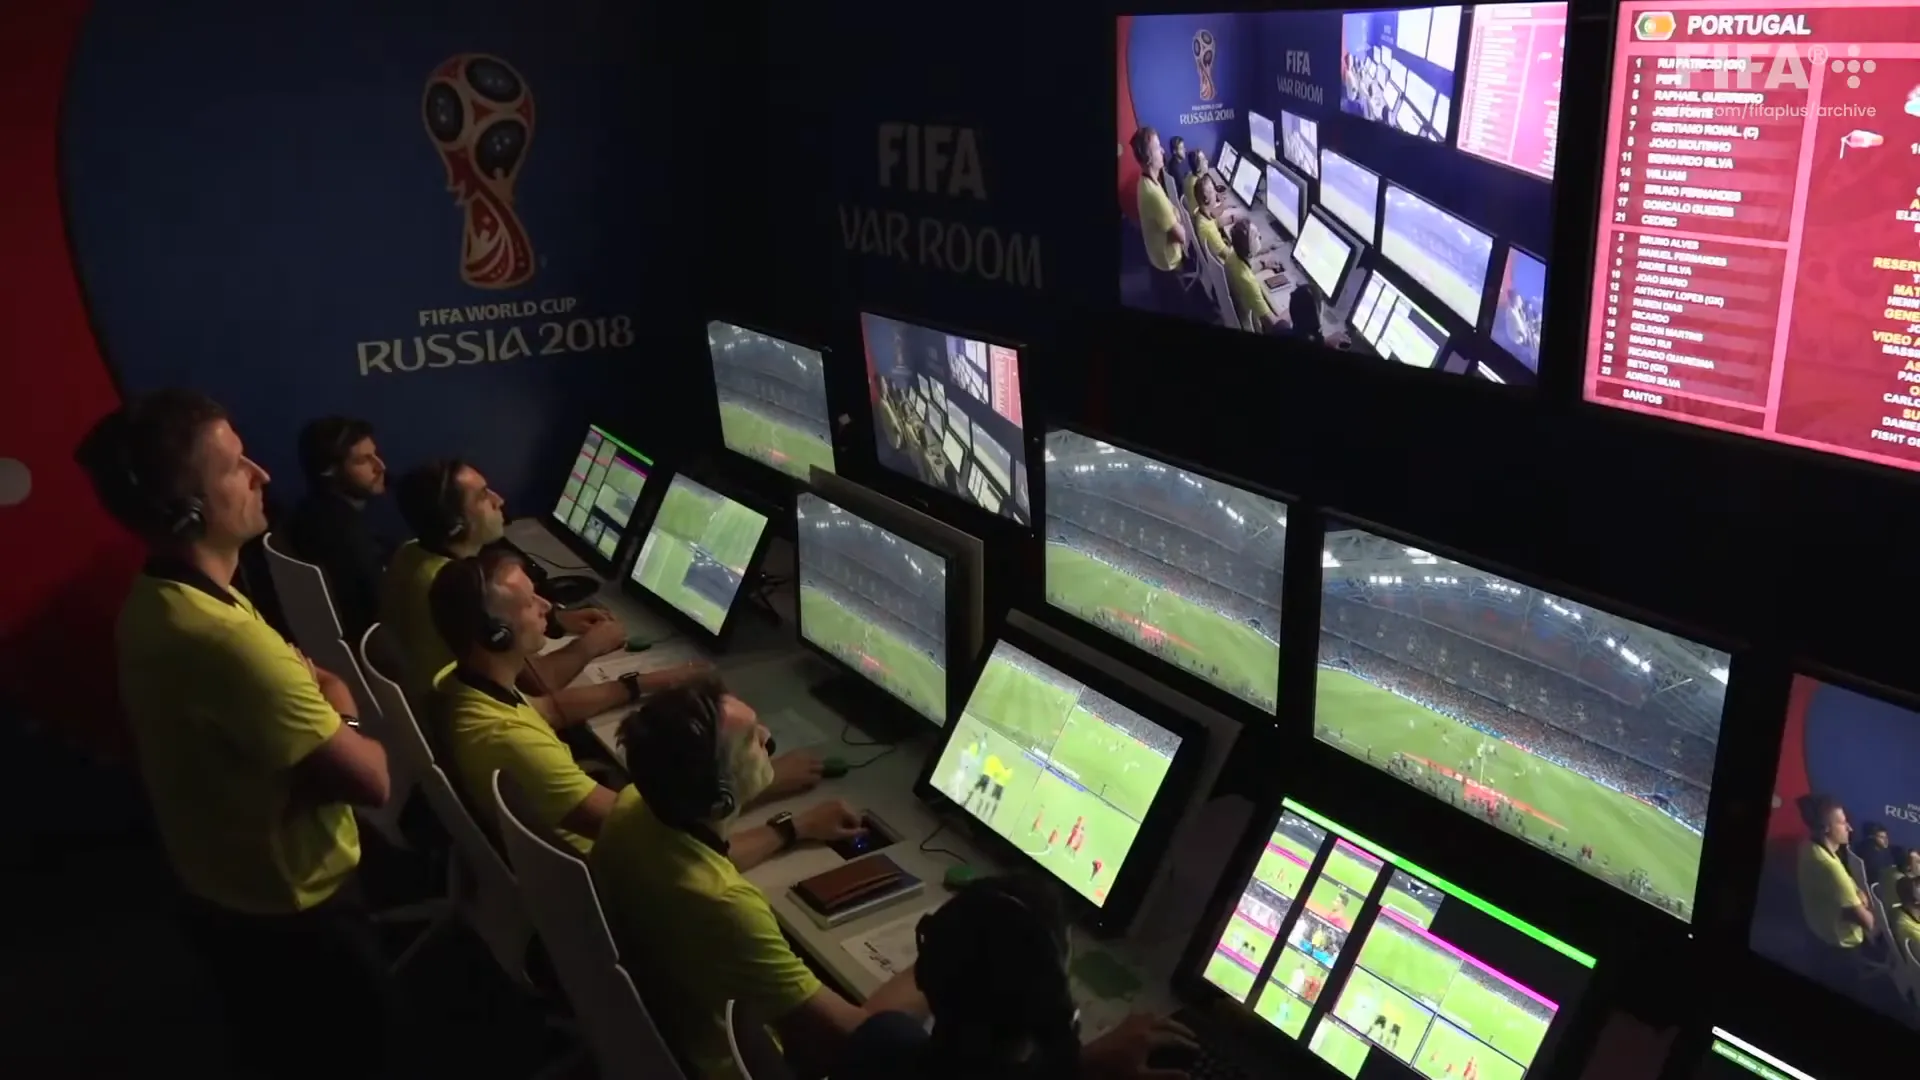
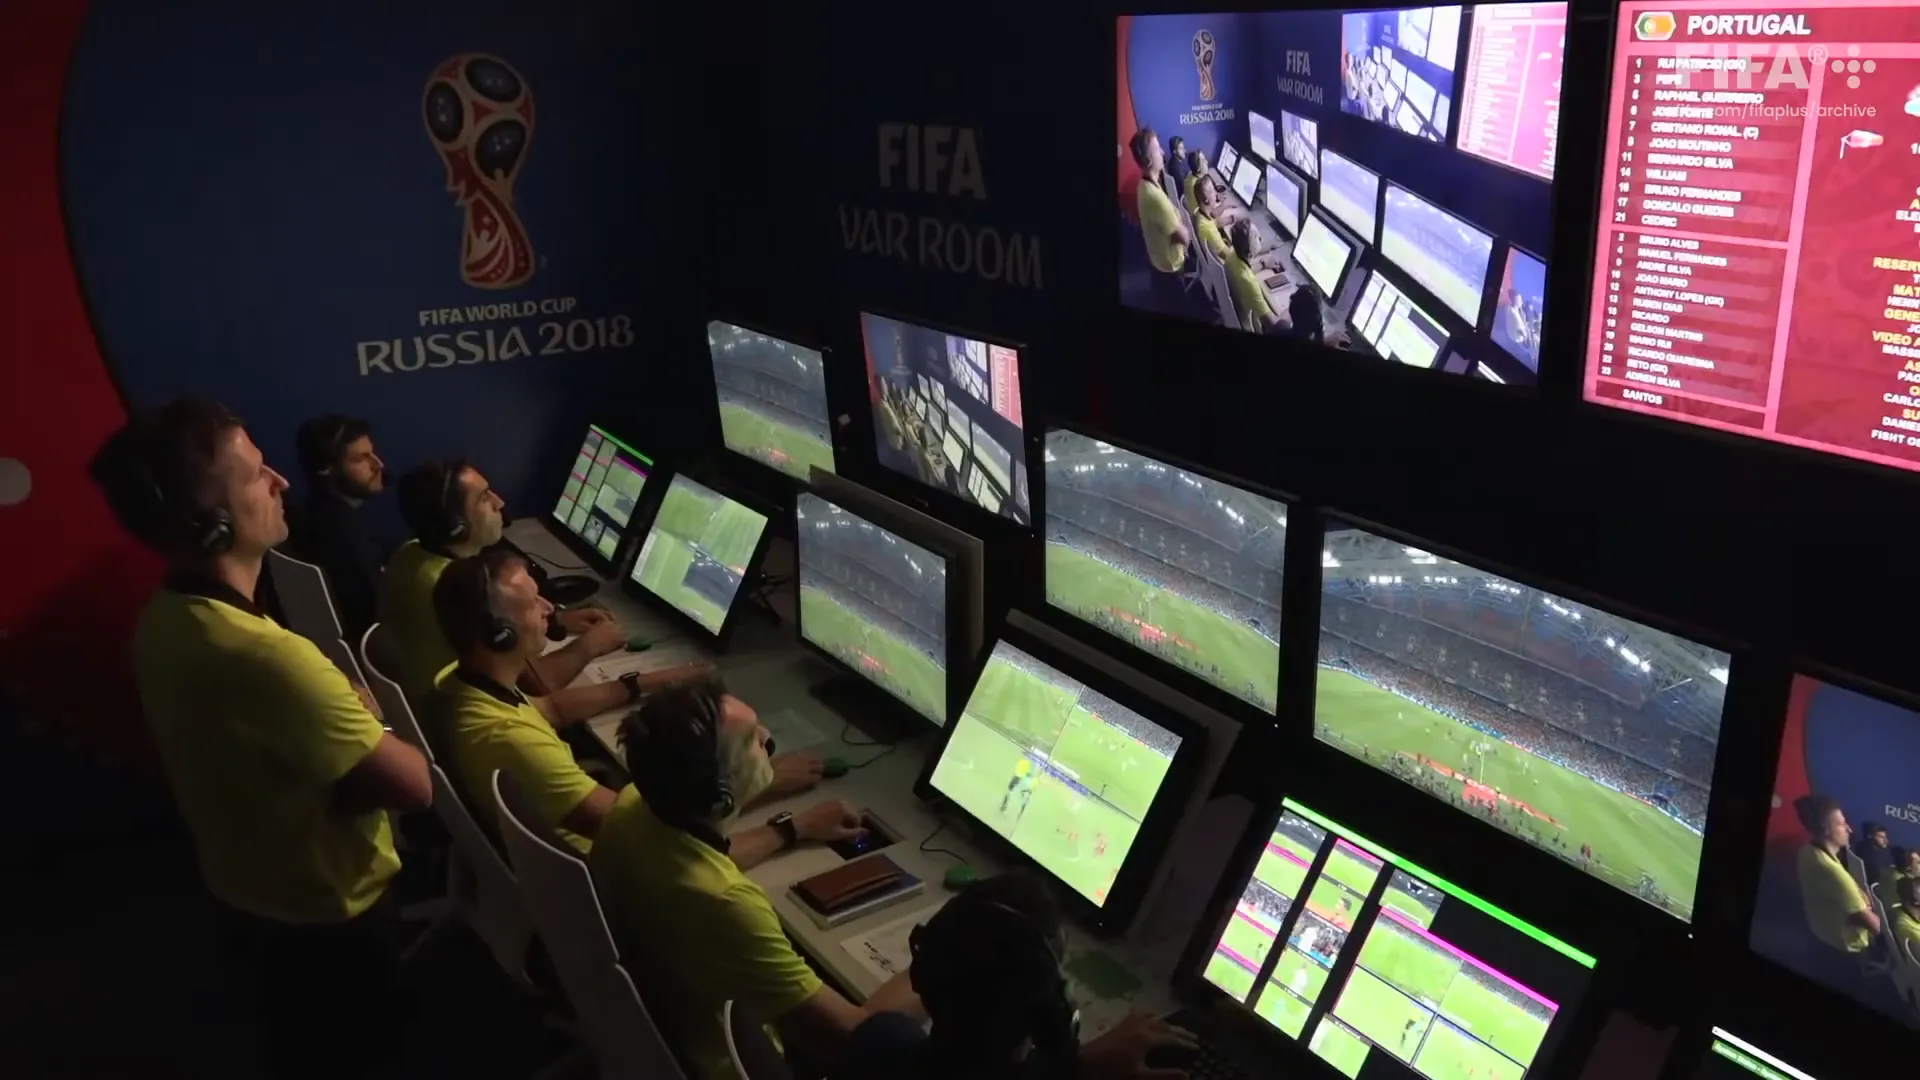
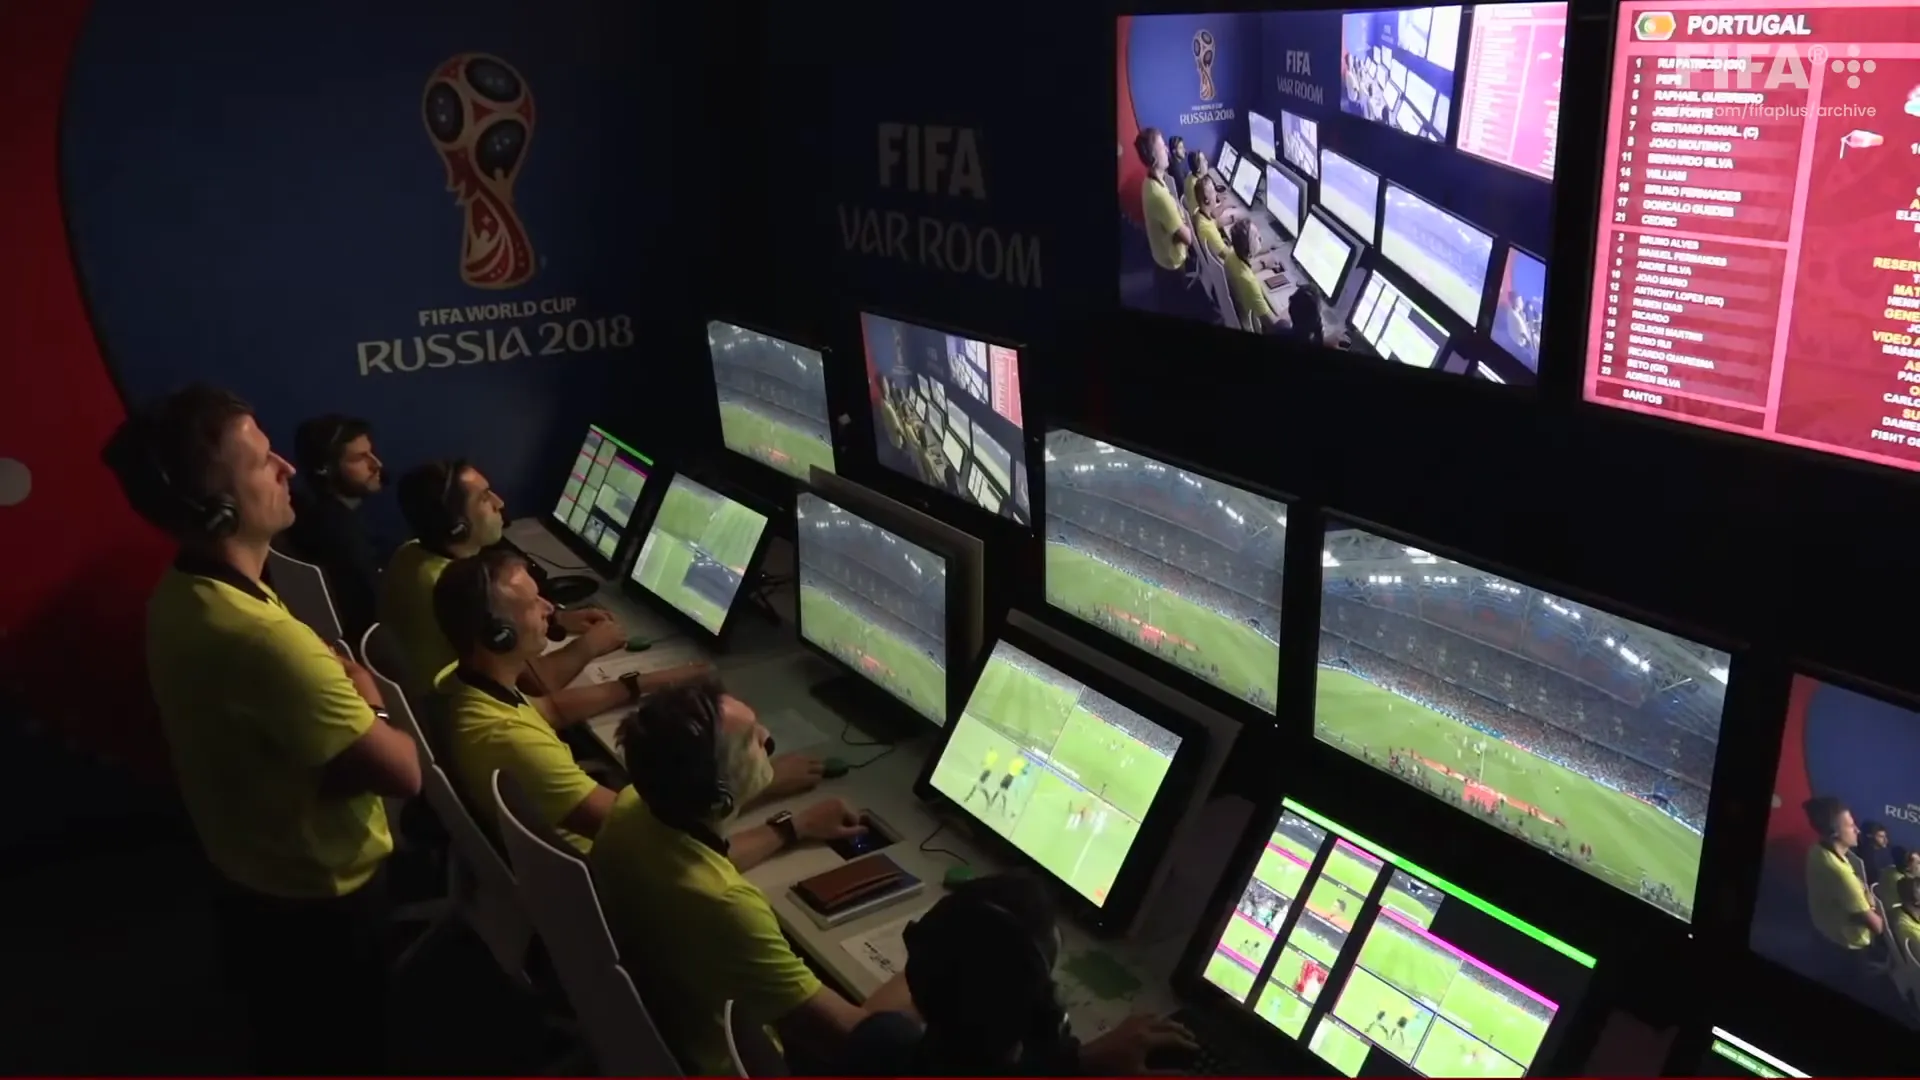
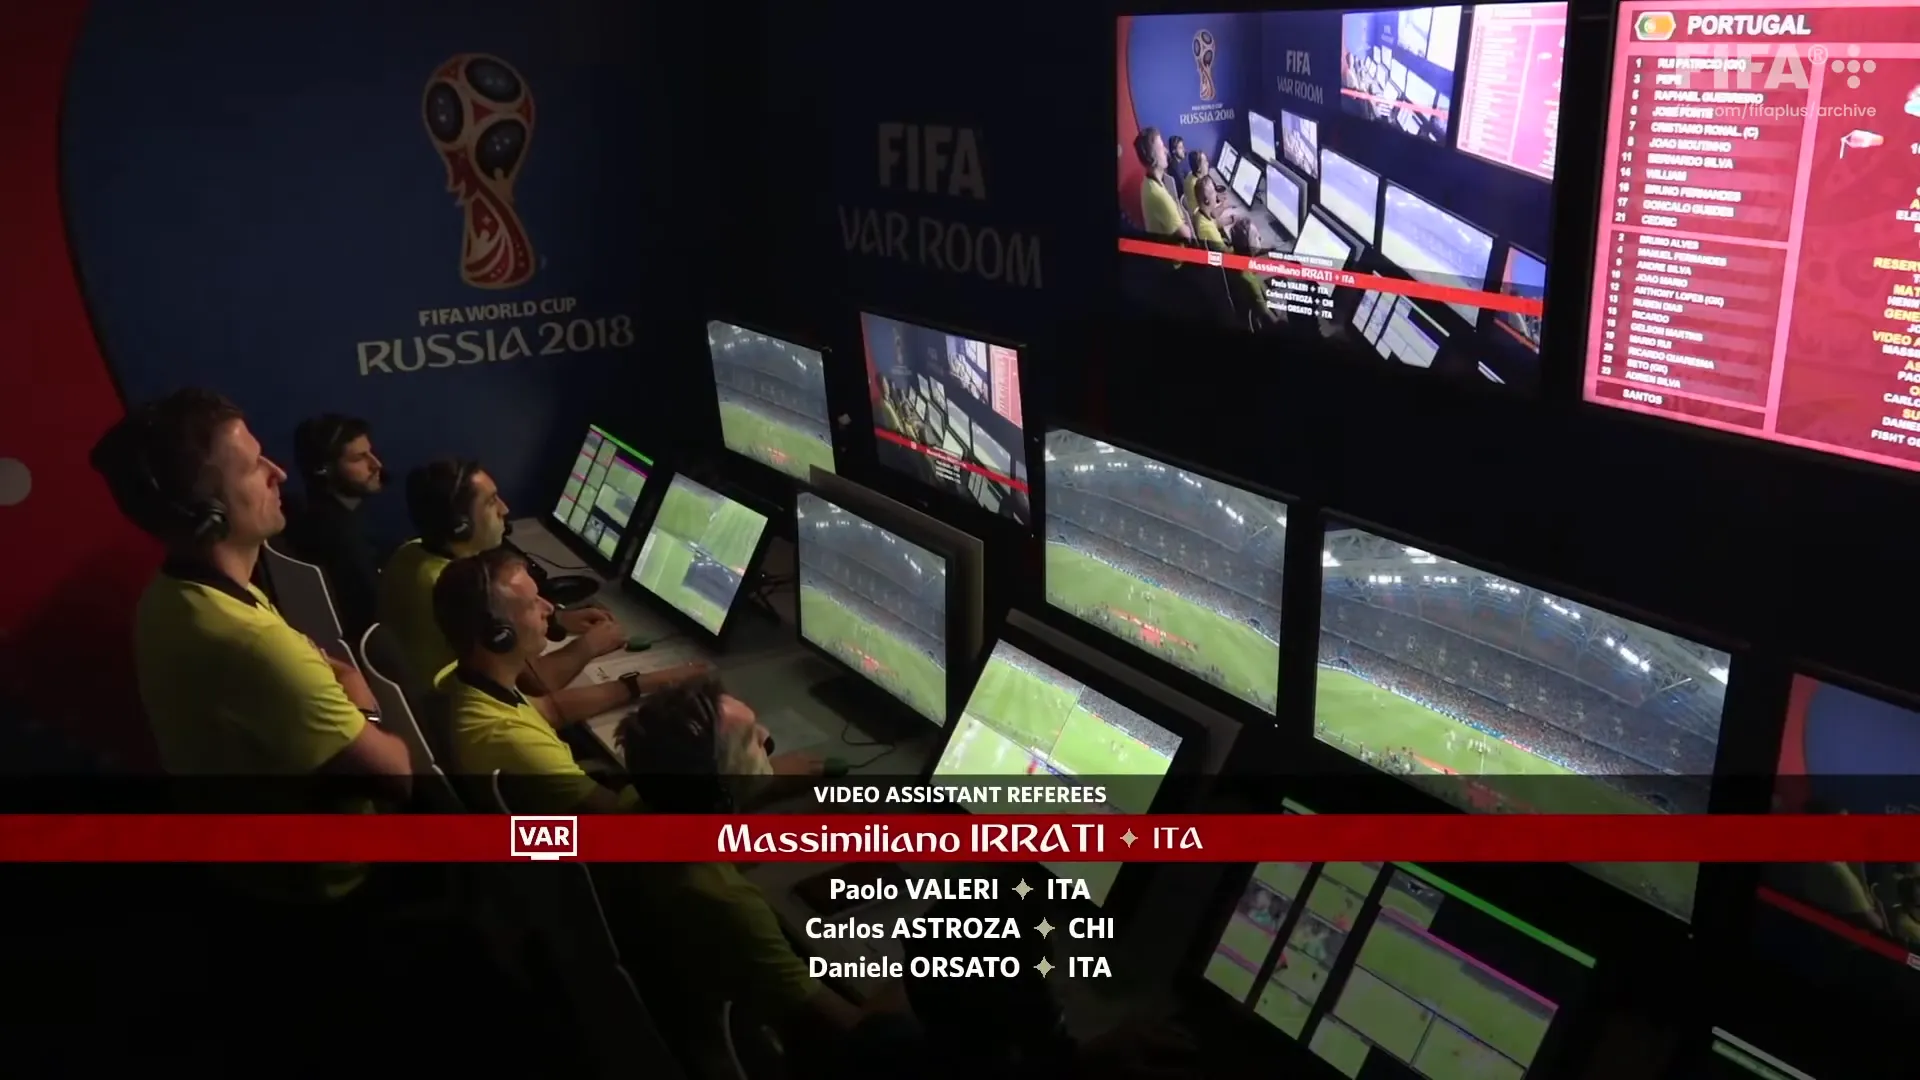

In [ ]:
results_text

In [ ]:
text_corpus = table.select(table.video_caption, table.transcription.text)


@pxt.udf
def compose_semantics(video_caption: pxt.type_system.String, transcript: pxt.type_system.Json) -> str:
    return f"{video_caption}.{transcript['text']}"

In [ ]:
text_corpus.show()

video_caption,transcription_text
"A soccer match is underway, with players from portugal and spain competing in a high-intensity game. The players are actively engaged in the game, with some in possession of the ball and others in defensive or offensive positions. The scoreboard indicates that the match is in the 0-0 scoreline, with the time at 0:36.",the red. Portugal in the all red. Spain tonight in the change colours of white with the red trim won by David Silva. It's away by Jose Fonk. Looking for the run up front of Guede. Ronaldo. Little double step over to start
"A soccer match is underway, with the main action being a player attempting to shoot the ball into the goal. The player in a red jersey is in possession of the ball and is dribbling towards the goal, with a player in a white jersey in close proximity, possibly attempting to defend or intercept. The goalkeeper, also in a green jersey, is positioned in front of the goal, ready to react to the play.",before we can take a look at
"A soccer match is underway, with players from portugal and spain competing in a high-intensity game. The players are actively engaged in the game, with some in possession of the ball and others in defensive or offensive positions. The scoreboard indicates that the match is in the 1st minute, with the score at 0-0.","from the 2016 European champions. They've won 79% of their competitive matches under Fernando Santos, just two defeats in 29. That's for Spain, the start of a new era under Fernando Iero. They were unbeaten under Gillian Lopategi."
"A soccer match is underway, with the main action being a player attempting to shoot the ball into the goal. The player in the red jersey is in the process of kicking the ball, which is in mid-air, while the player in the white jersey is running towards the ball, attempting to intercept it. The scoreboard at the top of the image shows the score as 0-0, with the time at 2:08, and the teams are portugal and spain.","I wonder what he's feeling now. The deposed national team coach. She was unveiled as Real Madrid's new coach yesterday. Ronaldo. Is that a penalty it is? Inside the opening three minutes, Cristiano Ronaldo fell in the penalty area and Portugal have the opportunity to take the lead. The challenge coming in."
"A group of soccer players are huddling together on the field, discussing a moment in the game. The players are standing in a circle, with one player in the center, wearing a red jersey with the number 7, who appears to be the focal point of their discussion. The other players are wearing yellow jerseys, indicating they are part of the opposing team.",at eight days ago. Portugal regularly used a 442 formation in qualifying where the gay dash plays just behind Ronaldo or alongside him we will just have to wait and see. Portugal have played in more World Cups with Cristiano Ronaldo than without. They're forced with their talisman. It's their seventh World Cup in all. Jan-lukaraqui from Italy is in
"The video shows a group of individuals engaged in the action of playing soccer, which involves walking, carrying/holding an object, and watching a person. The players are seated in a control room, surrounded by multiple screens displaying various images and data related to the game, including a live feed of the soccer match and tactical analysis. The screens are arranged in a semi-circle, and the players are wearing yellow shirts, indicating they are part of the same team.","to Italian assistance. Ra'Yuzin Sato from Japan is the fourth official. And back in Moscow, there is the line up of VAR officials, led by Massa Miliano Irati from Italy. David DeHaie was an ever-presenting qualifying. Many of this Spanish team we know."
"The video shows a soccer match between spain and another team, with the players from spain wearing red jerseys with the number 6 on the front, and the opposing team's players wearing white jerseys with the number 1 on the front. The players are standing on a soccer field wit

In [ ]:
table.columns

['video',
 'audio',
 'transcription',
 'metadata',
 'video_caption',
 'text',
 'fulltext']

In [ ]:
import pixeltable as pxt
from pixeltable.functions import huggingface
from pixeltable.iterators.string import StringSplitter

embed_model = huggingface.sentence_transformer.using(model_id="all-MiniLM-L6-v2")

table.add_computed_column(fulltext=compose_semantics(table.video_caption, table.transcription), if_exists="replace")

# FIXME: not ok, because each sentecen will be composed with the video description
# and it'll make duplicates when embedding
text_view = pxt.create_view(
    "textdata", table, iterator=StringSplitter.create(text=table.fulltext, separators="sentence"), if_exists="replace"
)


Added 10 column values with 0 errors.
Inserting rows into `textdata`: 73 rows [00:00, 24812.33 rows/s]
Created view `textdata` with 73 rows, 0 exceptions.


In [ ]:
table.select(text_view.fulltext).show(10)

fulltext
"A soccer match is underway, with players from portugal and spain competing in a high-intensity game. The players are actively engaged in the game, with some in possession of the ball and others in defensive or offensive positions. The scoreboard indicates that the match is in the 0-0 scoreline, with the time at 0:36.. the red. Portugal in the all red. Spain tonight in the change colours of white with the red trim won by David Silva. It's away by Jose Fonk. Looking for the run up front of Guede. Ronaldo. Little double step over to start"
"A soccer match is underway, with the main action being a player attempting to shoot the ball into the goal. The player in a red jersey is in possession of the ball and is dribbling towards the goal, with a player in a white jersey in close proximity, possibly attempting to defend or intercept. The goalkeeper, also in a green jersey, is positioned in front of the goal, ready to react to the play.. before we can take a look at"
"A soccer match is underway, with players from portugal and spain competing in a high-intensity game. The players are actively engaged in the game, with some in possession of the ball and others in defensive or offensive positions. The scoreboard indicates that the match is in the 1st minute, with the score at 0-0.. from the 2016 European champions. They've won 79% of their competitive matches under Fernando Santos, just two defeats in 29. That's for Spain, the start of a new era under Fernando Iero. They were unbeaten under Gillian Lopategi."
"A soccer match is underway, with the main action being a player attempting to shoot the ball into the goal. The player in the red jersey is in the process of kicking the ball, which is in mid-air, while the player in the white jersey is running towards the ball, attempting to intercept it. The scoreboard at the top of the image shows the score as 0-0, with the time at 2:08, and the teams are portugal and spain.. I wonder what he's feeling now. The deposed national team coach. She was unveiled as Real Madrid's new coach yesterday. Ronaldo. Is that a penalty it is? Inside the opening three minutes, Cristiano Ronaldo fell in the penalty area and Portugal have the opportunity to take the lead. The challenge coming in."
"A group of soccer players are huddling together on the field, discussing a moment in the game. The players are standing in a circle, with one player in the center, wearing a red jersey with the number 7, who appears to be the focal point of their discussion. The other players are wearing yellow jerseys, indicating they are part of the opposing team.. at eight days ago. Portugal regularly used a 442 formation in qualifying where the gay dash plays just behind Ronaldo or alongside him we will just have to wait and see. Portugal have played in more World Cups with Cristiano Ronaldo than without. They're forced with their talisman. It's their seventh World Cup in all. Jan-lukaraqui from Italy is in"
"The video shows a group of individuals engaged in the action of playing soccer, which involves walking, carrying/holding an object, and watching a person. The players are seated in a control room, surrounded by multiple screens displaying various images and data related to the game, including a live feed of the soccer match and tactical analysis. The screens are arranged in a semi-circle, and the players are wearing yellow shirts, indicating they are part of the same team.. to Italian assistance. Ra'Yuzin Sato from Japan is the fourth official. And back in Moscow, there is the line up of VAR officials, led by Massa Miliano Irati from Italy. David DeHaie was an ever-presenting qualifying. Many of this Spanish team we know."
"The video shows a soccer match between spain and another team, with the players from spain wearing red jerseys with the number 6 on the front, and the opposing team's players wearing white jerseys with the number 1 on the front. The players are standing on a soccer field with a green surface and wh

In [ ]:
print(table)
table.select(table.video, table.fulltext).show(3)

Table
'poc.data'

    Column Name    Type                                      Computed With
          video   Video                                                   
          audio   Audio                 extract_audio(video, format='mp3')
  transcription    Json           transcribe(audio=audio, model='base.en')
       metadata    Json                                get_metadata(audio)
  video_caption  String  core.functions.caption_video(video=video, prom...
           text  String    compose_semantics(video_caption, transcription)
       fulltext  String    compose_semantics(video_caption, transcription)


FileNotFoundError: [Errno 2] No such file or directory: '/tmp/video_chunks_ffmpeg_sub_p_zkqqqx/chunk_006.mp4'

                                               video  \
0  /tmp/video_chunks_ffmpeg_sub_p_zkqqqx/chunk_00...   
1  /tmp/video_chunks_ffmpeg_sub_p_zkqqqx/chunk_00...   
2  /tmp/video_chunks_ffmpeg_sub_p_zkqqqx/chunk_00...   

                                            fulltext  
0  A soccer match is underway, with players from ...  
1  A soccer match is underway, with the main acti...  
2  A soccer match is underway, with players from ...  

In [ ]:
texts = table.select(table.fulltext).collect().to_pandas()

In [ ]:
texts.to_csv("texts_csv.csv")

In [ ]:
from pixeltable.functions.huggingface import sentence_transformer
from pixeltable.iterators.string import StringSplitter

embd_func = sentence_transformer.using(model_id="sentence-transformers/all-MiniLM-L12-v2")
sentences_view = pxt.create_view(
    "sentences", table, iterator=StringSplitter.create(text=table.fulltext, separators="sentence"), if_exists="replace"
)
sentences_view.select(sentences_view.text, sentences_view.pos).show(3)


Inserting rows into `sentences`: 73 rows [00:00, 31558.87 rows/s]
Created view `sentences` with 73 rows, 0 exceptions.


text,pos
"A soccer match is underway, with players from portugal and spain competing in a high-intensity game.",0
"The players are actively engaged in the game, with some in possession of the ball and others in defensive or offensive positions.",1
"The scoreboard indicates that the match is in the 0-0 scoreline, with the time at 0:36.. the red.",2


In [ ]:
from pixeltable.functions.huggingface import sentence_transformer

sentences_view.add_embedding_index("text", embedding=sentence_transformer.using(model_id="intfloat/e5-large-v2"))

In [ ]:
import pixeltable as pxt
from pixeltable.functions import whisper
from pixeltable.functions.huggingface import sentence_transformer
from pixeltable.functions.video import extract_audio
from pixeltable.iterators import AudioSplitter, FrameIterator
from pixeltable.iterators.string import StringSplitter

pxt_cache = "mvp"
table_name = "video_data"
full_table_name = f"{pxt_cache}.{table_name}"
frames_view_name = f"{pxt_cache}.{table_name}_frames"
audio_view_name = f"{pxt_cache}.{table_name}_audio_chunks"
sentences_view_name = f"{pxt_cache}.{table_name}_sentences"
semantics_index_name = f"{pxt_cache}.{table_name}_semanticindex"

pxt.drop_dir(pxt_cache, if_not_exists="ignore", force=True)
pxt.create_dir(pxt_cache, if_exists="ignore")

video_table = pxt.create_table(
    full_table_name,
    {"video": pxt.Video},
    if_exists="replace_force",
)

video_table.insert(
    [
        {
            "video": "/home/razvantalexandru/Documents/Projects/NeuralBits/multimodal-agents-course/.cache/por_vs_esp_5min/2018_portugal_vs_spain_T0h0m_0h5m copy.mp4"
        }
    ],
    if_exists="replace_force",
)

video_table.add_computed_column(
    audio_extract=extract_audio(video_table.video, format="mp3"),
    if_exists="replace_force",
)

audio_chunks = pxt.create_view(
    audio_view_name,
    video_table,
    iterator=AudioSplitter.create(
        audio=video_table.audio_extract,
        chunk_duration_sec=30.0,
        overlap_sec=1,
        min_chunk_duration_sec=1.0,
    ),
    if_exists="replace_force",
)

audio_chunks.add_computed_column(
    transcription=whisper.transcribe(audio=audio_chunks.audio_chunk, model="base.en"),
    if_exists="replace_force",
)

# # Step 5: Combine semantics (caption + transcription)
# video_table.add_computed_column(
#     semantics=compose_semantics(video_table.video_caption, video_table.transcription),
#     if_exists="replace",
# )

# sentences_view = pxt.create_view(
#     sentences_view_name,
#     audio_chunks,
#     iterator=StringSplitter.create(text=audio_chunks.transcription.text, separators="sentence"),
#     if_exists="replace_force",
# )

# video_table.add_embedding_index(
#     column=video_table.semantics,  # this comes from L80, as iterator creates `text` rows`
#     idx_name=semantics_index_name,
#     string_embed=sentence_transformer.using(model_id="intfloat/e5-large-v2"),
#     if_exists="ignore",
# )

frames_view = pxt.create_view(
    frames_view_name,
    video_table,
    iterator=FrameIterator.create(video=video_table.video, fps=1.0),  # FIXME: move to config
    if_exists="ignore",
)

Created directory 'mvp'.
Created table `video_data`.
Inserting rows into `video_data`: 1 rows [00:00, 764.97 rows/s]
Inserted 1 row with 0 errors.
Added 1 column value with 0 errors.
Inserting rows into `video_data_audio_chunks`: 11 rows [00:00, 4934.48 rows/s]
Created view `video_data_audio_chunks` with 11 rows, 0 exceptions.
Added 11 column values with 0 errors.
Inserting rows into `video_data_frames`: 300 rows [00:00, 35806.93 rows/s]
Created view `video_data_frames` with 300 rows, 0 exceptions.


In [ ]:
# frames_view.show(1)
audio_chunks.select(
    audio_chunks.audio_chunk,
    audio_chunks.start_time_sec,
    audio_chunks.transcription.text,
    audio_chunks.end_time_sec,
).show(10)

audio_chunk,start_time_sec,transcription_text,end_time_sec
,0.023,,30.
,29.04,"is in charge to Italian assistance. Ra'Yu-Shi-Sato from Japan is the fourth official. And back in Moscow, there is the line up of VAR officials led by Massa Miliano Irati from Italy. David DeHaie was an ever-presenting qualifying. Many of the...",59.016
,58.032,qualifying. Many of this Spanish team we know would have started no matter who the coaches. Sergio Puskats is arguably Spain's most important player. Andres Iniesta scored the extra time winner when Spain beat the Netherlands in the 2010 World Cup final. Sergio Ramos captains Spain new coach Fernando Iero was Ramos's hero when he was growing up. Diego Costa leads the attack. Four of this starting eleven started the World Cup final in South Africa eight years ago.,88.008
,87.024,"the limous cracks019th,USE Williearo Wanted from his post of Sporting Director.",117.
,116.04,director to head coach.,146.016
,145.032,"A huge draw as this match gets underway. Spain and Portugal who have both lost their opening match in the last two World Cups. The stage is set here in Sochi for what could be a World Cup Classic to remember for many years. It is a humid night despite the late kickoff time. It's 9 o'clock in the evening here at local time to Iberian neighbours, Cristiano Ronaldo.",175.008
,174.024,Ronaldo facing four of his Real Madrid teammates. Portugal in the all-red Spain tonight in their change colours of white with the red trim won by David Silva. It's away by Jose Faunt. Looking for the run up front of Guedej.,204.
,203.04,And now the little double step over to start with. Peppa. Here's William. Good at it. Good at it. The little ball in field looking for Fernandez. Good at it.,233.016
,232.032,"Guesdesh shot was blocked but maybe Portugal can get a shot in here. Good opening from the 2016 European champions. They've won 79% of their competitive matches under Fernando Santos, just two defeats in 29. As for Spain, the start of a new era.",262.008
,261.024,out of a new era under Fernando Iero. They were unbeaten under Julien Lopategi. And I wonder what he's feeling now. The deposed national team coach. She was unveiled as Real Madrid's new coach yesterday. Ronaldo. Is that a penalty it is? Inside the opening three minutes. Cristiano Ronaldo fell in the penalty area and Portugal.,291.


frame,pos_msec
,0.
,1000.

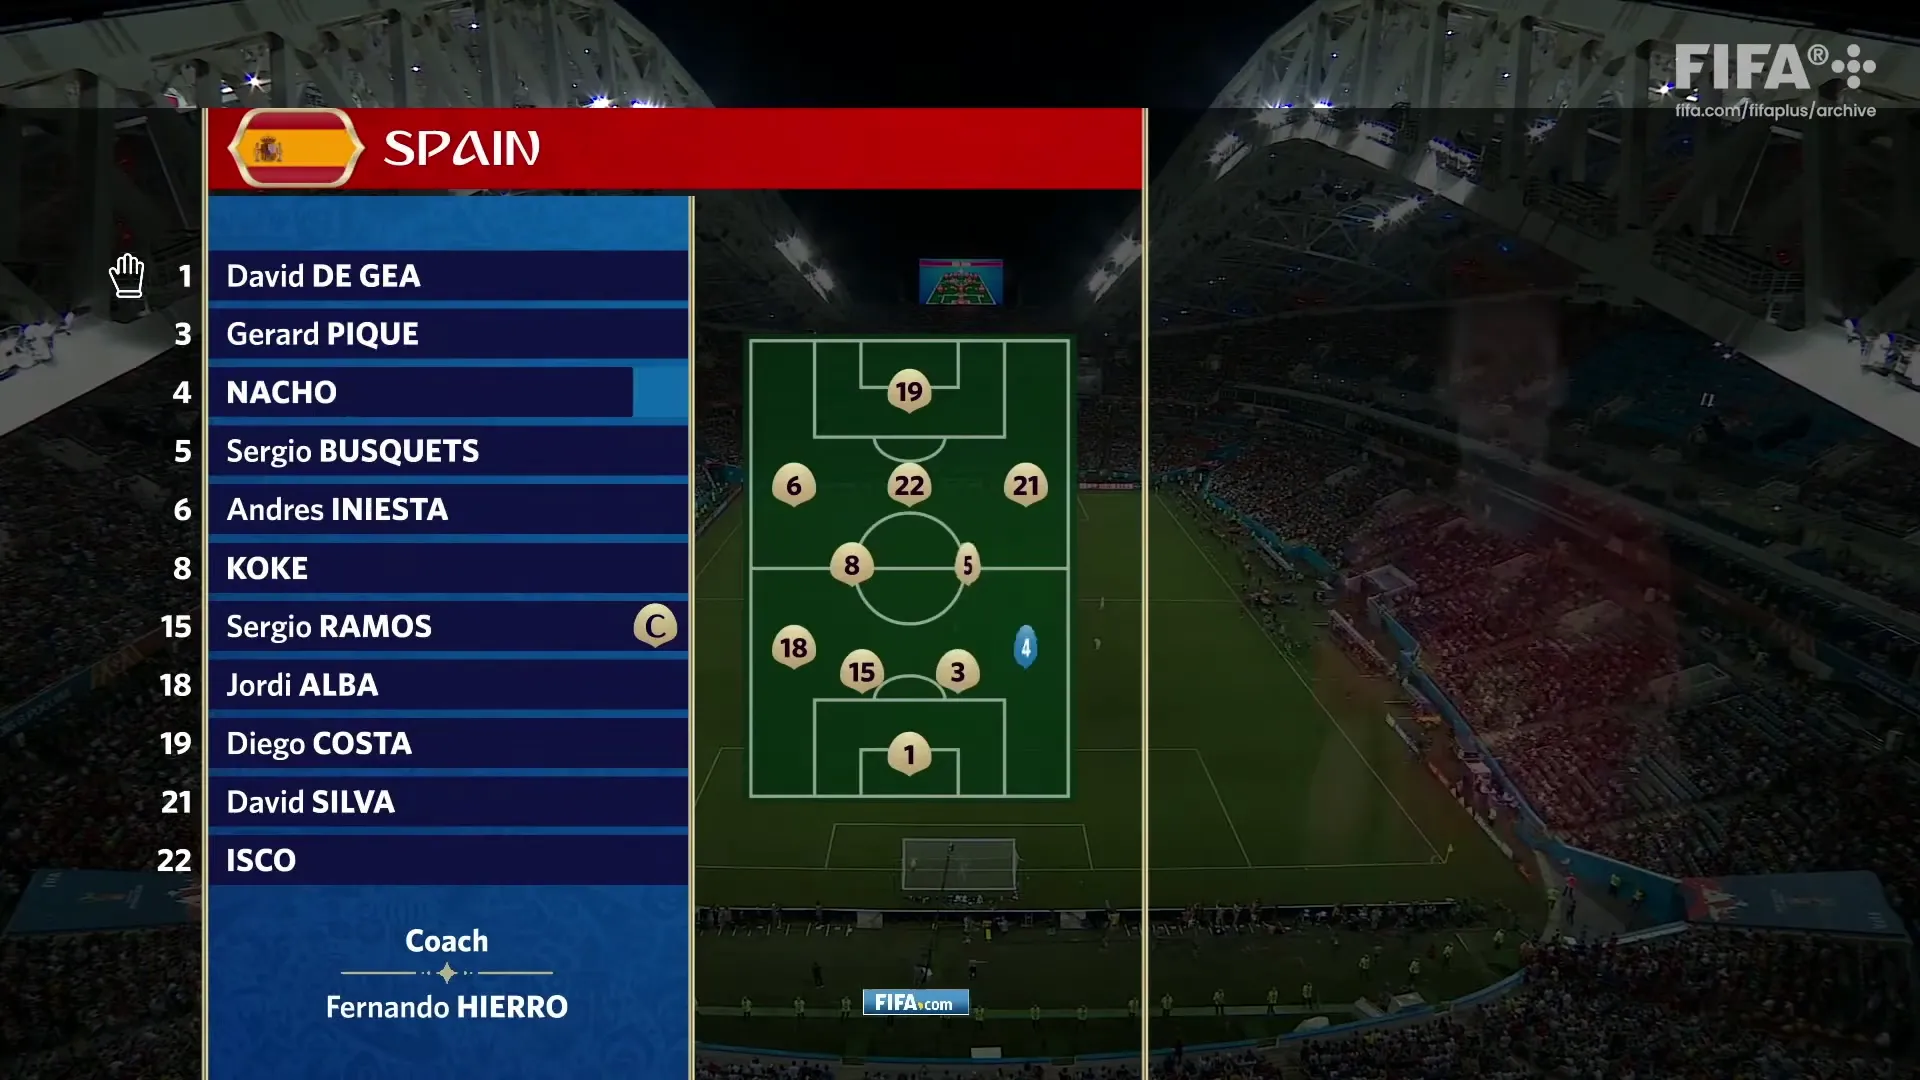
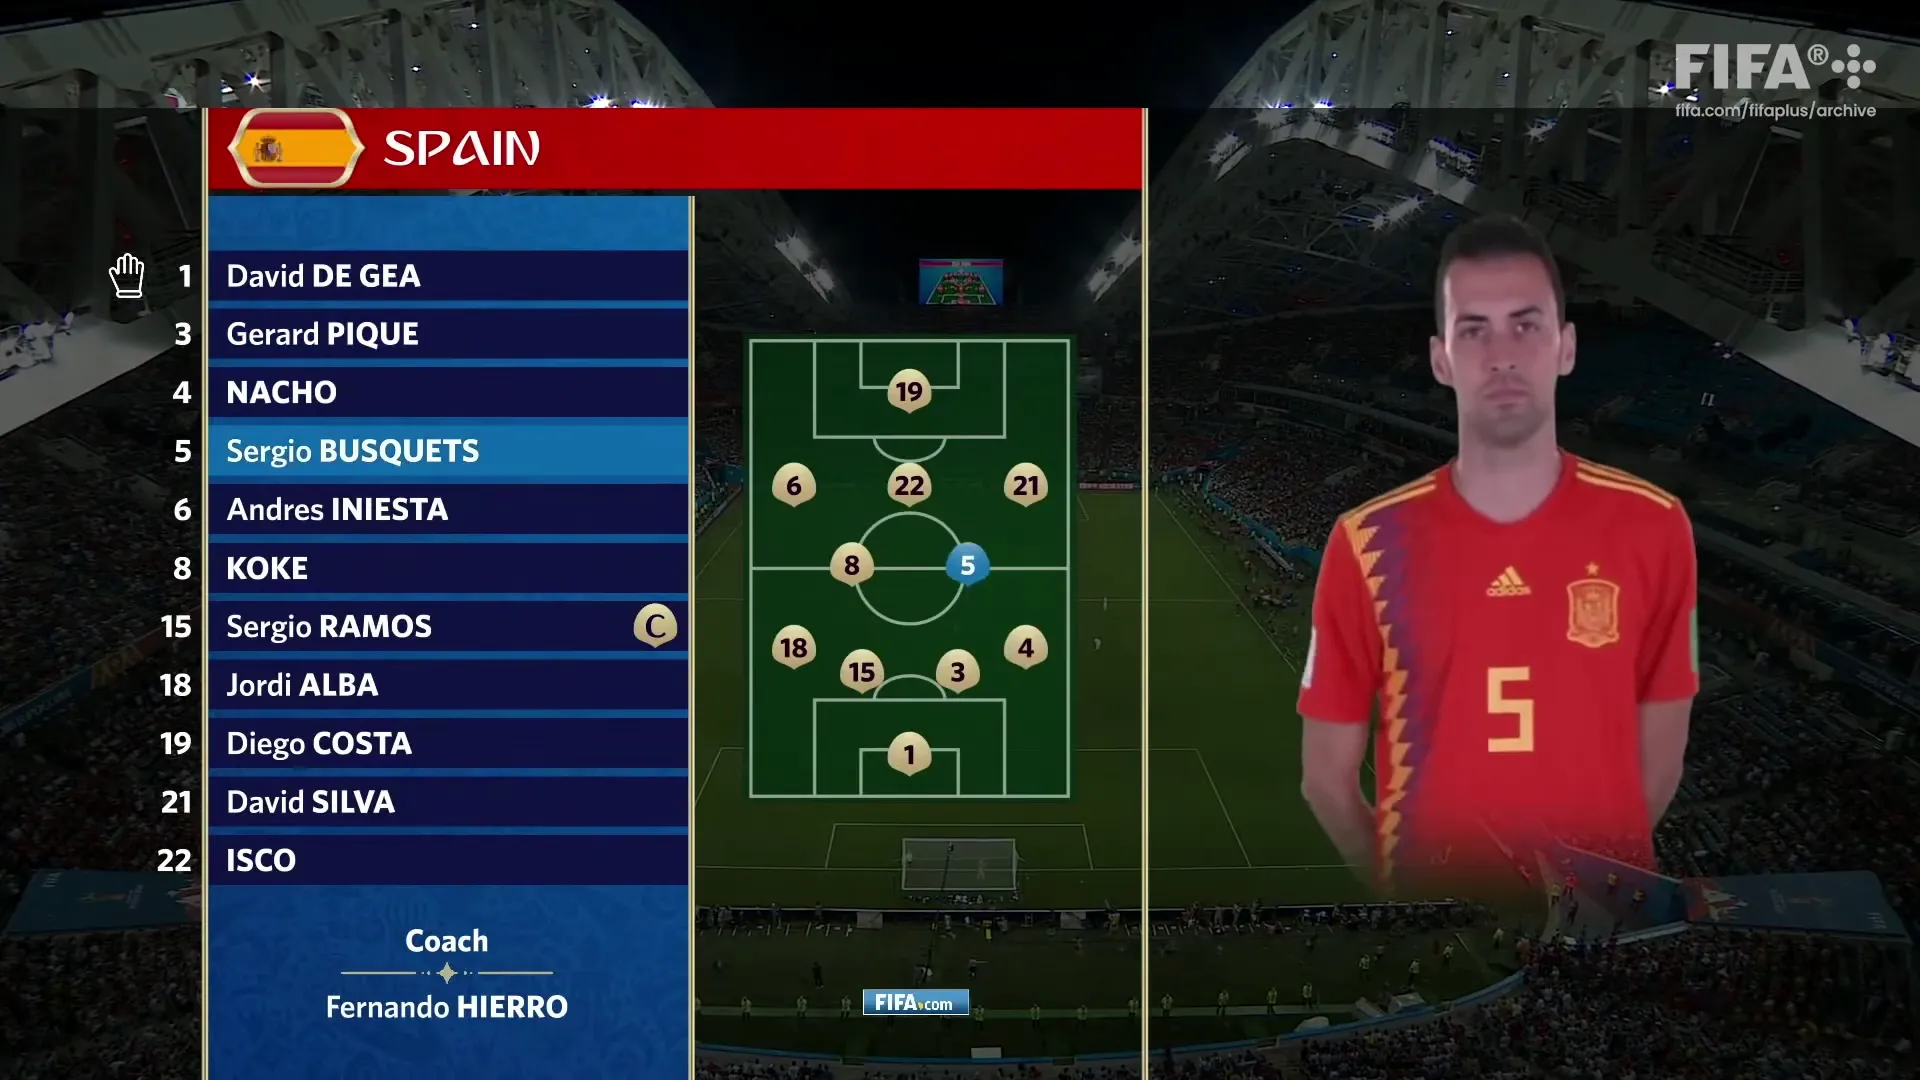

In [ ]:
frames_view.select(
    frames_view.frame,
    frames_view.pos_msec,
).show(2)

In [ ]:
print(frames_view.columns)
print(audio_chunks.columns)

['pos', 'frame_idx', 'pos_msec', 'pos_frame', 'frame', 'video', 'audio_extract']
['pos', 'start_time_sec', 'end_time_sec', 'audio_chunk', 'transcription', 'video', 'audio_extract']


In [ ]:
audio_chunks.show(3)

In [ ]:
from pixeltable.iterators.string import StringSplitter

sentences = pxt.create_view(
    "sentences_view",
    audio_chunks,
    iterator=StringSplitter.create(
        text=audio_chunks.transcription.text,
        separators="sentence",
    ),
    if_exists="ignore",
)


sentences.add_embedding_index(
    column=sentences.text,
    string_embed=sentence_transformer.using(model_id="intfloat/e5-large-v2"),
    if_exists="replace_force",
)

Inserting rows into `sentences_view`: 47 rows [00:00, 29688.60 rows/s]
Created view `sentences_view` with 47 rows, 0 exceptions.


In [ ]:
sims = sentences.text.similarity("Did anyone score a goal?")
topk = 5
results_df = (
    sentences.select(
        sentences.text,
        sentences.pos,
        sentences.start_time_sec,
        sentences.end_time_sec,
        similarity=sims,
    )
    .order_by(sims, asc=False)
    .limit(topk)
    .collect()
    .to_pandas()
)

In [ ]:
best_entry_index = results_df["similarity"].idxmax()

best_start_time = results_df.loc[best_entry_index, "start_time_sec"]
best_end_time = results_df.loc[best_entry_index, "end_time_sec"]

['pos',
 'frame_idx',
 'pos_msec',
 'pos_frame',
 'frame',
 'video',
 'audio_extract']

In [ ]:
frames = (
    frames_view.select(
        frames_view.frame,
    )
    .where((frames_view.pos_msec >= best_start_time * 1e3) & (frames_view.pos_msec <= best_end_time * 1e3))
    .order_by(frames_view.frame_idx)
)


In [ ]:
df = frames.collect().to_pandas()


Video saved to: output.mp4


In [ ]:
sentences.where((sentences.start_time_sec > 260 & sentences.start_time_sec < 300)).select(
    audio_chunks.audio_chunk,
    audio_chunks.start_time_sec,
    audio_chunks.transcription.text,
    audio_chunks.end_time_sec,
).show(10)

TypeError: unsupported operand type(s) for &: 'int' and 'ColumnRef'

text.similarity('Cristiano Ronaldo')

In [ ]:
@pxt.query
def get_relevant_context(query_text: str, limit: int = 3):
    sim = text_view.text.similarity(query_text)
    # Return a list of strings (text of relevant chunks)
    return text_view.order_by(sim, asc=False).limit(limit).select(text_view.text)

In [ ]:
from pixeltable.functions import whisper
from pixeltable.functions.huggingface import sentence_transformer
from pixeltable.functions.video import extract_audio
from pixeltable.iterators import AudioSplitter
from pixeltable.iterators.string import StringSplitter
from pixeltable.iterators.video import FrameIterator


@pxt.udf
def transcript_to_str(transcript: pxt.type_system.Json) -> str:
    return f"{transcript['text']}"


video_table = pxt.create_table(
    "video_table",
    {"video": pxt.Video},
    if_exists="replace_force",
)

video_table.insert(
    [
        {
            "video": "/home/razvantalexandru/Documents/Projects/NeuralBits/multimodal-agents-course/.cache/por_vs_esp_5min/2018_portugal_vs_spain_T0h0m_0h5m copy.mp4"
        }
    ],
    if_exists="replace_force",
)

video_table.add_computed_column(
    audio_extract=extract_audio(video_table.video, format="mp3"),
    if_exists="replace_force",
)

audio_chunks = pxt.create_view(
    "audio_chunks",
    video_table,
    iterator=AudioSplitter.create(
        audio=video_table.audio_extract,
        chunk_duration_sec=30.0,
        overlap_sec=0.0,
        min_chunk_duration_sec=5.0,
    ),
    if_exists="replace_force",
)

audio_chunks.add_computed_column(
    transcription=whisper.transcribe(audio=audio_chunks.audio_chunk, model="base.en"),
    if_exists="replace_force",
)


audio_chunks.add_computed_column(
    text=transcript_to_str(audio_chunks.transcription),
    if_exists="replace_force",
)

frames_view = pxt.create_view(
    "frames_view",
    video_table,
    iterator=FrameIterator.create(video=video_table.video, fps=1.0),  # FIXME: move to config
    if_exists="replace_force",
)

sentences_view = pxt.create_view(
    "sentences",
    audio_chunks,
    iterator=StringSplitter.create(text=audio_chunks.transcription.text, separators="sentence"),
    if_exists="replace_force",
)


sentences_view.add_embedding_index(
    idx_name="sentences_index",
    column=sentences_view.text,  # this comes from L80, as iterator creates `text` rows`
    string_embed=sentence_transformer.using(model_id="intfloat/e5-large-v2"),
    if_exists="replace_force",
)

Created table `video_table`.
Inserting rows into `video_table`: 1 rows [00:00, 569.72 rows/s]
Inserted 1 row with 0 errors.
Added 1 column value with 0 errors.
Inserting rows into `audio_chunks`: 10 rows [00:00, 4654.13 rows/s]
Created view `audio_chunks` with 10 rows, 0 exceptions.
['pos', 'start_time_sec', 'end_time_sec', 'audio_chunk', 'video', 'audio_extract']
Added 10 column values with 0 errors.
Inserting rows into `frames_view`: 300 rows [00:00, 33821.40 rows/s]
Created view `frames_view` with 300 rows, 0 exceptions.


/home/razvantalexandru/Documents/Projects/NeuralBits/multimodal-agents-course/ingestion/.venv/lib/python3.12/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.7.1) was trained with spaCy v3.7.2 and may not be 100% compatible with the current version (3.8.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


Inserting rows into `sentences`: 46 rows [00:00, 24933.83 rows/s]
Created view `sentences` with 46 rows, 0 exceptions.
Added 10 column values with 0 errors.


In [ ]:
audio_chunks.add_embedding_index(
    column=audio_chunks.text,
    idx_name="audio_chunks_index",
    string_embed=sentence_transformer.using(model_id="intfloat/e5-large-v2"),
    if_exists="replace_force",
)


In [2]:
import pixeltable as pxt

audio_chunks = pxt.get_table("audio_chunks")

sims = audio_chunks.text.similarity("Cristiano Ronaldo penalty", idx="audio_chunks_index")
results = audio_chunks.select(
    audio_chunks.text,
    audio_chunks.start_time_sec,
    audio_chunks.end_time_sec,
    similarity=sims,
).order_by(sims, asc=False)

Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/home/razvantalexandru/.pixeltable/pgdata


In [ ]:
from pathlib import Path

import cv2
import numpy as np


def create_video(frames, output_path: str, fps: int) -> str:
    """Create a video from a list of frames using OpenCV.

    Args:
        frames: The list of PIL.Image.Image frames.
        output_path: The path to save the video.
        fps: Frames per second for the video.

    Returns:
        The path to the created video.
    """
    out_file = Path(output_path)
    if not frames:
        raise ValueError("The frames list is empty.")

    # Get the dimensions of the first frame
    frame_width, frame_height = frames[0].size
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")  # Codec for .mp4 files
    video_writer = cv2.VideoWriter(str(out_file), fourcc, fps, (frame_width, frame_height))

    for frame in frames:
        # Convert PIL.Image.Image to a NumPy array and then to BGR format for OpenCV
        frame_array = np.array(frame.convert("RGB"))
        frame_bgr = cv2.cvtColor(frame_array, cv2.COLOR_RGB2BGR)
        video_writer.write(frame_bgr)

    video_writer.release()
    return str(out_file)


In [5]:
frames_view = pxt.get_table("frames_view")
top_k_entries = results.limit(3).collect()
for i, entry in enumerate(top_k_entries):
    start_time_sec = float(entry["start_time_sec"])
    end_time_sec = float(entry["end_time_sec"])

    sampled_frames = (
        frames_view.select(
            frames_view.frame_idx,
            frames_view.frame,
        )
        .where((frames_view.pos_msec >= start_time_sec * 1e3) & (frames_view.pos_msec <= end_time_sec * 1e3))
        .collect()
    )
    frames = [entry["frame"] for entry in sampled_frames]
    print(len(frames))
    clip_path = create_video(
        frames,
        f"/home/razvantalexandru/Documents/Projects/NeuralBits/multimodal-agents-course/notebooks/clip_{i}.mp4",
        fps=5,
    )
    print(f"Clip {i} saved to: {clip_path}")

29
Clip 0 saved to: /home/razvantalexandru/Documents/Projects/NeuralBits/multimodal-agents-course/notebooks/clip_0.mp4
30
Clip 1 saved to: /home/razvantalexandru/Documents/Projects/NeuralBits/multimodal-agents-course/notebooks/clip_1.mp4
30
Clip 2 saved to: /home/razvantalexandru/Documents/Projects/NeuralBits/multimodal-agents-course/notebooks/clip_2.mp4


In [ ]:
sampled_frames = frames_view.select(
    frames_view.frame_idx,
    frames_view.frame,
).where((frames_view.pos_msec >= start_time * 1e3) & (frames_view.pos_msec <= end_time * 1e3))

In [ ]:
collected_frames = sampled_frames.collect()
frames = collected_frames["frame"]

In [63]:
vpath = create_video_from_dataframe(frames, "output.mp4", fps=5)

In [ ]:
audio_chunks.select(audio_chunks.text, audio_chunks.start_time_sec, audio_chunks.end_time_sec).order_by(
    audio_chunks.start_time_sec
).show(100)

In [ ]:
import pixeltable as pxt

sentences_view = pxt.get_table("sentences")
print(sentences_view.columns)
sims = sentences_view.text.similarity("Cristiano Ronaldo penalty")
results = sentences_view.select(
    sentences_view.pos,
    sentences_view.text,
    sentences_view.start_time_sec,
    sentences_view.end_time_sec,
    similarity=sims,
).order_by(sims, asc=False)


['pos', 'text', 'start_time_sec', 'end_time_sec', 'audio_chunk', 'transcription', 'video', 'audio_extract']


In [17]:
results.show()

pos,text,start_time_sec,end_time_sec,similarity
8,Cristiano Ronaldo fell in the penalty area and Portugal.,261.024,291.,0.873
8,Cristiano Ronaldo fell in the penalty area and Portugal.,261.024,291.,0.873
8,Cristiano Ronaldo fell in the penalty area and Portugal.,261.024,291.,0.873
8,Cristiano Ronaldo fell in the penalty area and Portugal.,261.024,291.,0.873
8,Cristiano Ronaldo fell in the penalty area and Portugal.,261.024,291.,0.873
5,Ronaldo.,261.024,291.,0.856
5,Ronaldo.,261.024,291.,0.856
5,Ronaldo.,261.024,291.,0.856
5,Ronaldo.,261.024,291.,0.856
5,Ronaldo.,261.024,291.,0.856


In [18]:
best_entry = results.limit(1).collect()
start_time = float(best_entry["start_time_sec"][-1])
end_time = float(best_entry["end_time_sec"][-1])

In [20]:
print(start_time, end_time)

261.024 291.0001


In [ ]:
# frames_view.select(frames_view.frame, frames_view.pos_msec).tail(10)

Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/home/razvantalexandru/.pixeltable/pgdata


Added 1500 column values with 0 errors.


UpdateStatus(num_rows=1500, num_computed_values=1500, num_excs=0, updated_cols=[], cols_with_excs=[])

In [ ]:
import PIL
import pixeltable as pxt
from pixeltable.ext.functions.yolox import yolox

frames_view = pxt.get_table("frames_view")
frames_view.add_computed_column(
    detections=yolox(
        frames_view.frame,
        model_id="yolox_tiny",
        threshold=0.25,
    ),
    if_exists="ignore",
)


@pxt.query
def get_relevant_timestamps(text_query: str, topk: int = 1):
    sim = sentences_view.text.similarity(text_query)
    results = sentences_view.select(
        sentences_view.pos,
        sentences_view.text,
        sentences_view.start_time_sec,
        sentences_view.end_time_sec,
        similarity=sim,
    ).order_by(sim, asc=False)

    best_entry = results.limit(topk).collect()
    start_time = float(best_entry["start_time_sec"][-1])
    end_time = float(best_entry["end_time_sec"][-1])

    return start_time, end_time


frames_view.add_computed_column(
    time_segments=get_relevant_timestamps(
        text_query="Cristiano Ronaldo penalty",
        topk=1,
    ),
    if_exists="ignore",
)


Error: similarity(): requires a string or a PIL.Image.Image object, not an expression

In [ ]:
sampled_frames = frames_view.select(
    frames_view.frame_idx,
    frames_view.frame,
).where((frames_view.pos_msec >= start_time * 1e3) & (frames_view.pos_msec <= end_time * 1e3))

sampled_frames


@pxt.udf
def draw_boxes(img: PIL.Image.Image, boxes: list[list[float]]) -> PIL.Image.Image:
    if not boxes:
        return img
    result = img.copy()
    d = PIL.ImageDraw.Draw(result)
    for box in boxes:
        d.rectangle(box, outline="red", width=3)
    return result


sentences_view = pxt.get_table("sentences")
print(sentences_view.columns)

selector = frames_view.select()
selector.where(selector)
# rss = sampled_frames.select(selector.frame, selector.detections).collect()

Name             Type     Expression
            pos    Required[Int]            pos
      frame_idx    Required[Int]      frame_idx
       pos_msec  Required[Float]       pos_msec
      pos_frame    Required[Int]      pos_frame
          frame  Required[Image]          frame
     detections   Required[Json]     detections
          video            Video          video
  audio_extract            Audio  audio_extract

From  frames_view

In [21]:
import pixeltable as pxt

# frames_view = pxt.get_table("frames_view")
sampled_frames = (
    frames_view.select(
        frames_view.frame_idx,
        frames_view.frame,
    )
    .where((frames_view.pos_msec >= start_time * 1e3) & (frames_view.pos_msec <= end_time * 1e3))
    .collect()
)


In [ ]:
len(sampled_frames)

150

: 

In [ ]:
img = sampled_frames["frame"][-1]
img.save("sampled_frame.png")

In [48]:
print(sampled_frames._col_names)
print(frames_view.columns)

['frame_idx', 'frame']
['pos', 'frame_idx', 'pos_msec', 'pos_frame', 'frame', 'video', 'audio_extract']


In [ ]:
print("SAMPLED:", sampled_frames["frame_idx"][-3:])

frames_view.select(frames_view.frame_idx).tail(3)

In [ ]:
frames_view.join(
    sampled_frames,
    on=frames_view.frame_idx == sampled_frames["frame_idx"][-1],
    how="inner",
).select(pxt.functions.video.make_video(frames_view.frame))


In [8]:
print(clip_path.as_dict())

{'_classname': 'DataFrame', 'from_clause': {'tbls': [{'tbl_version': {'id': '7da4d426-b918-4b17-ac45-c5e0eef94e20', 'effective_version': None}, 'base': {'tbl_version': {'id': 'c75da99e-d2f5-43dc-9e4f-a5848613c4a6', 'effective_version': None}, 'base': None}}], 'join_clauses': []}, 'select_list': [({'_classname': 'FunctionCall', 'fn': {'_classpath': 'pixeltable.func.aggregate_function.AggregateFunction', 'path': 'pixeltable.functions.video.make_video', 'signature': {'return_type': {'_classname': 'VideoType', 'nullable': False}, 'parameters': [{'name': 'frame', 'col_type': {'_classname': 'ImageType', 'nullable': False, 'width': None, 'height': None, 'mode': None}, 'kind': 'POSITIONAL_OR_KEYWORD', 'is_batched': False, 'default': None}, {'name': 'fps', 'col_type': {'_classname': 'IntType', 'nullable': False}, 'kind': 'KEYWORD_ONLY', 'is_batched': False, 'default': {'_classname': 'Literal', 'val': 25}}], 'is_batched': False}}, 'return_type': {'_classname': 'VideoType', 'nullable': False}, 'a

In [21]:
import pixeltable as pxt

video_table = pxt.get_table("cache_c0e0.table")
audio_chunks = pxt.get_table("cache_c0e0.table_audio_chunks")
video_frames = pxt.get_table("cache_c0e0.table_frames")

print(video_table.columns)
print(audio_chunks.columns)
print(video_frames.columns)

['video', 'audio_extract', 'video_caption']
['pos', 'start_time_sec', 'end_time_sec', 'audio_chunk', 'transcription', 'chunk_text', 'video', 'audio_extract', 'video_caption']
['pos', 'frame_idx', 'pos_msec', 'pos_frame', 'frame', 'video', 'audio_extract', 'video_caption']


In [14]:
sims = audio_chunks.chunk_text.similarity("Cristiano Ronaldo fell in the penalty")
results = audio_chunks.select(
    # audio_chunks.pos,
    # audio_chunks.chunk_text,
    # audio_chunks.start_time_sec,
    # audio_chunks.end_time_sec,
    similarity=sims,
).order_by(sims, asc=False)


frame_idx,frame,pos_msec
47,,47000.
48,,48000.
49,,49000.
50,,50000.
51,,51000.
52,,52000.
53,,53000.
54,,54000.
55,,55000.
56,,56000.

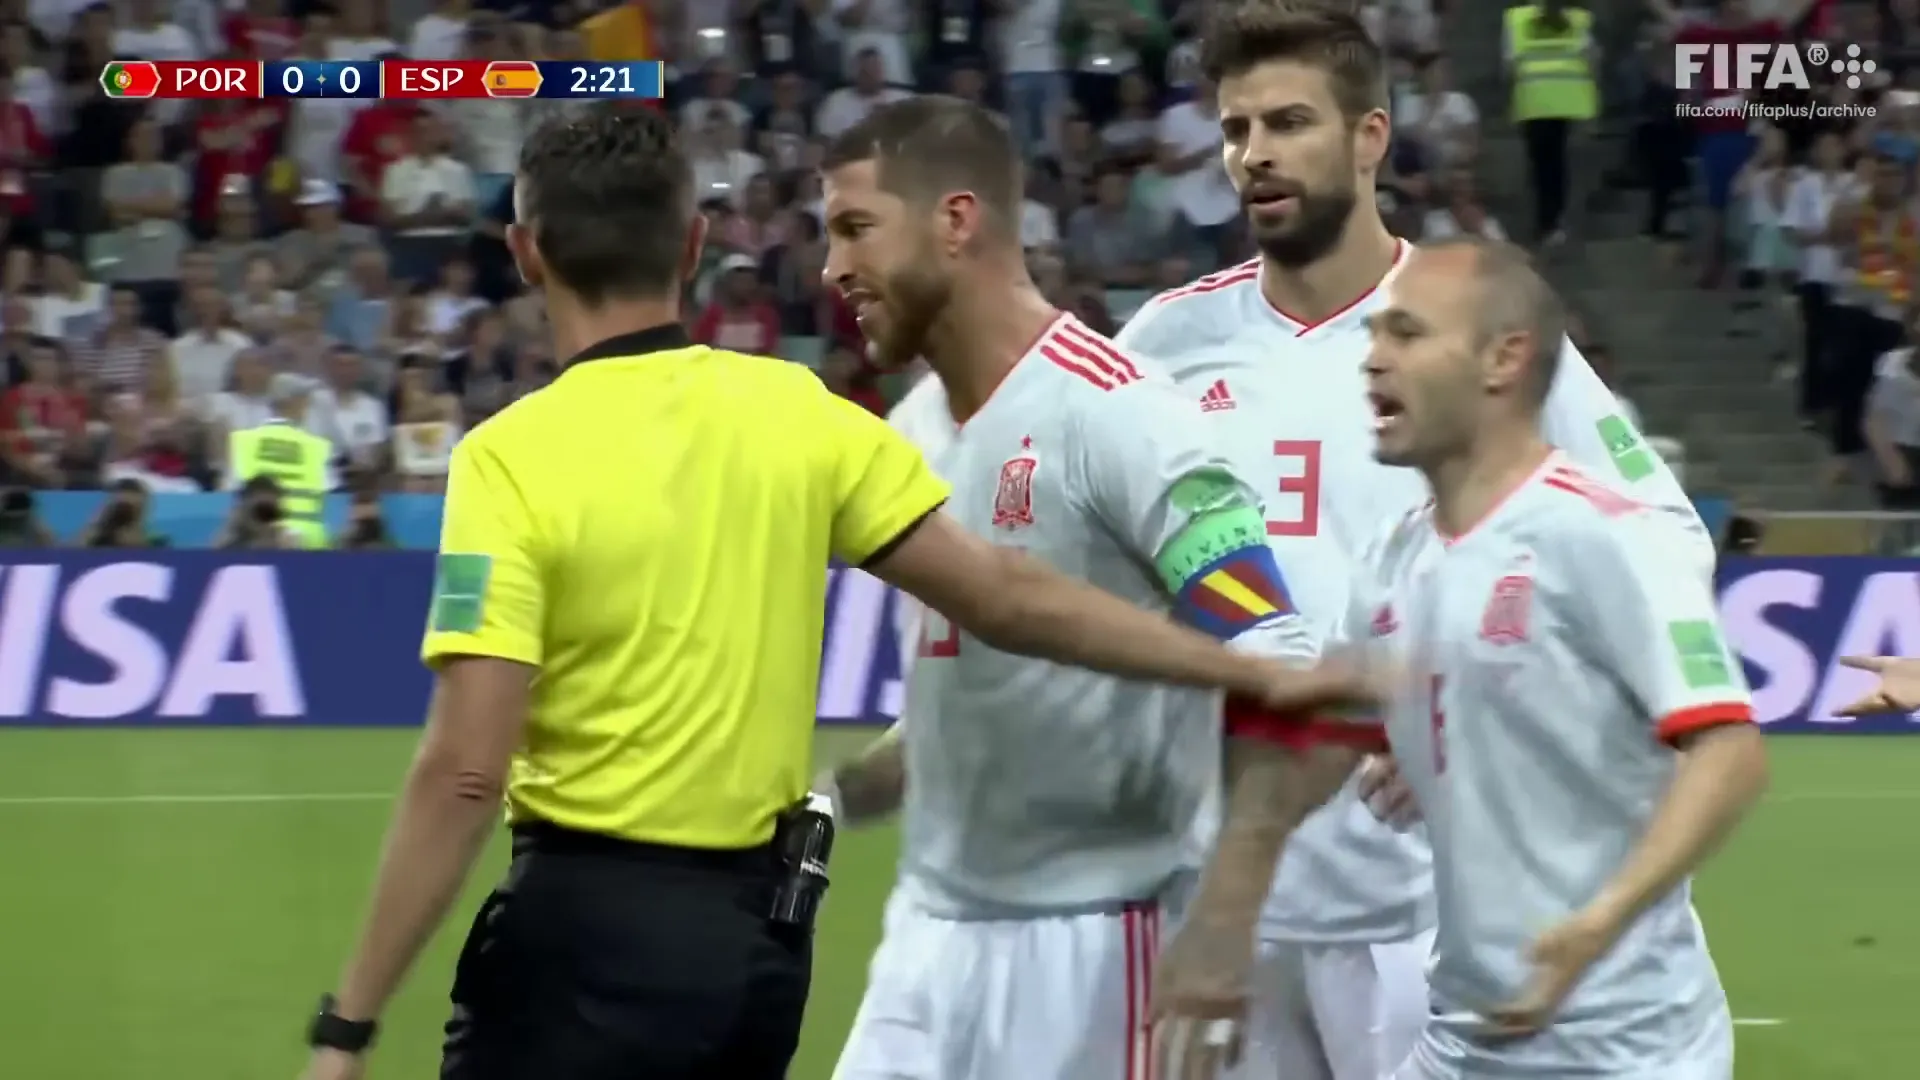
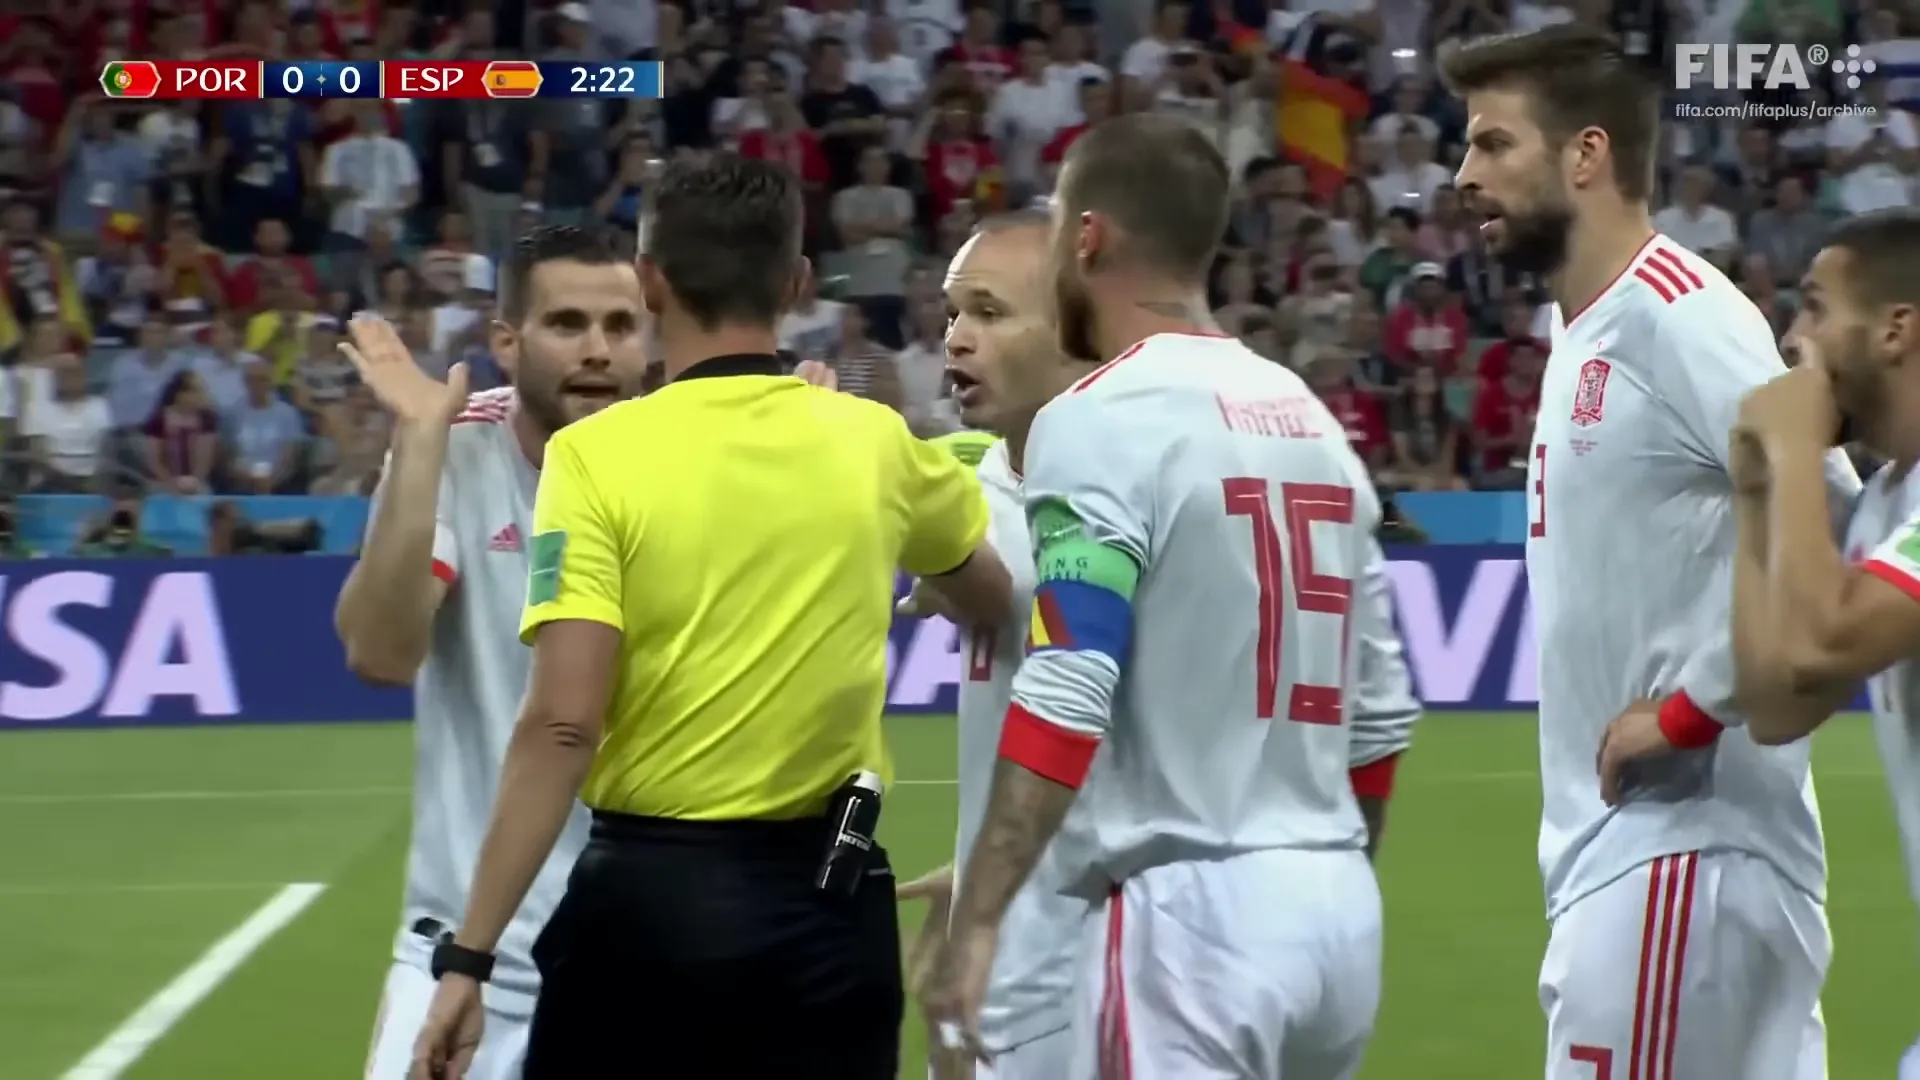
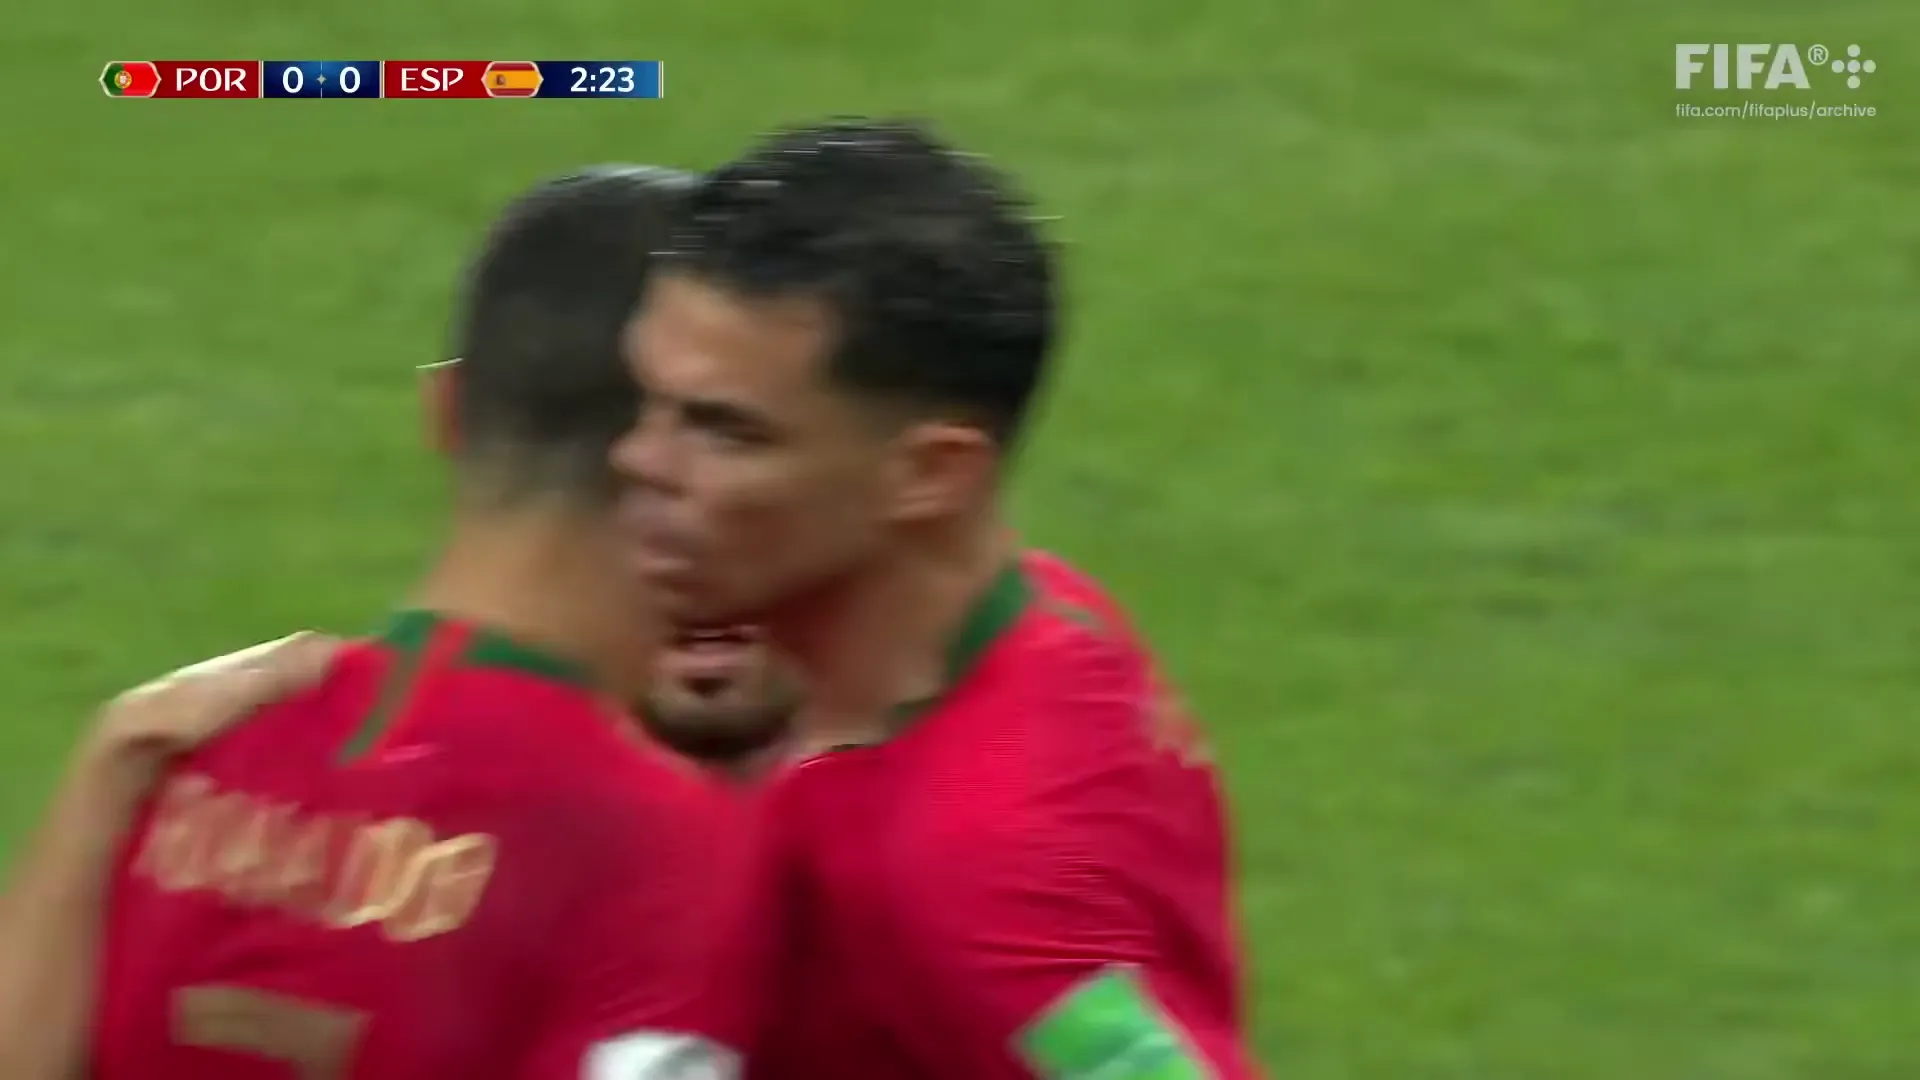
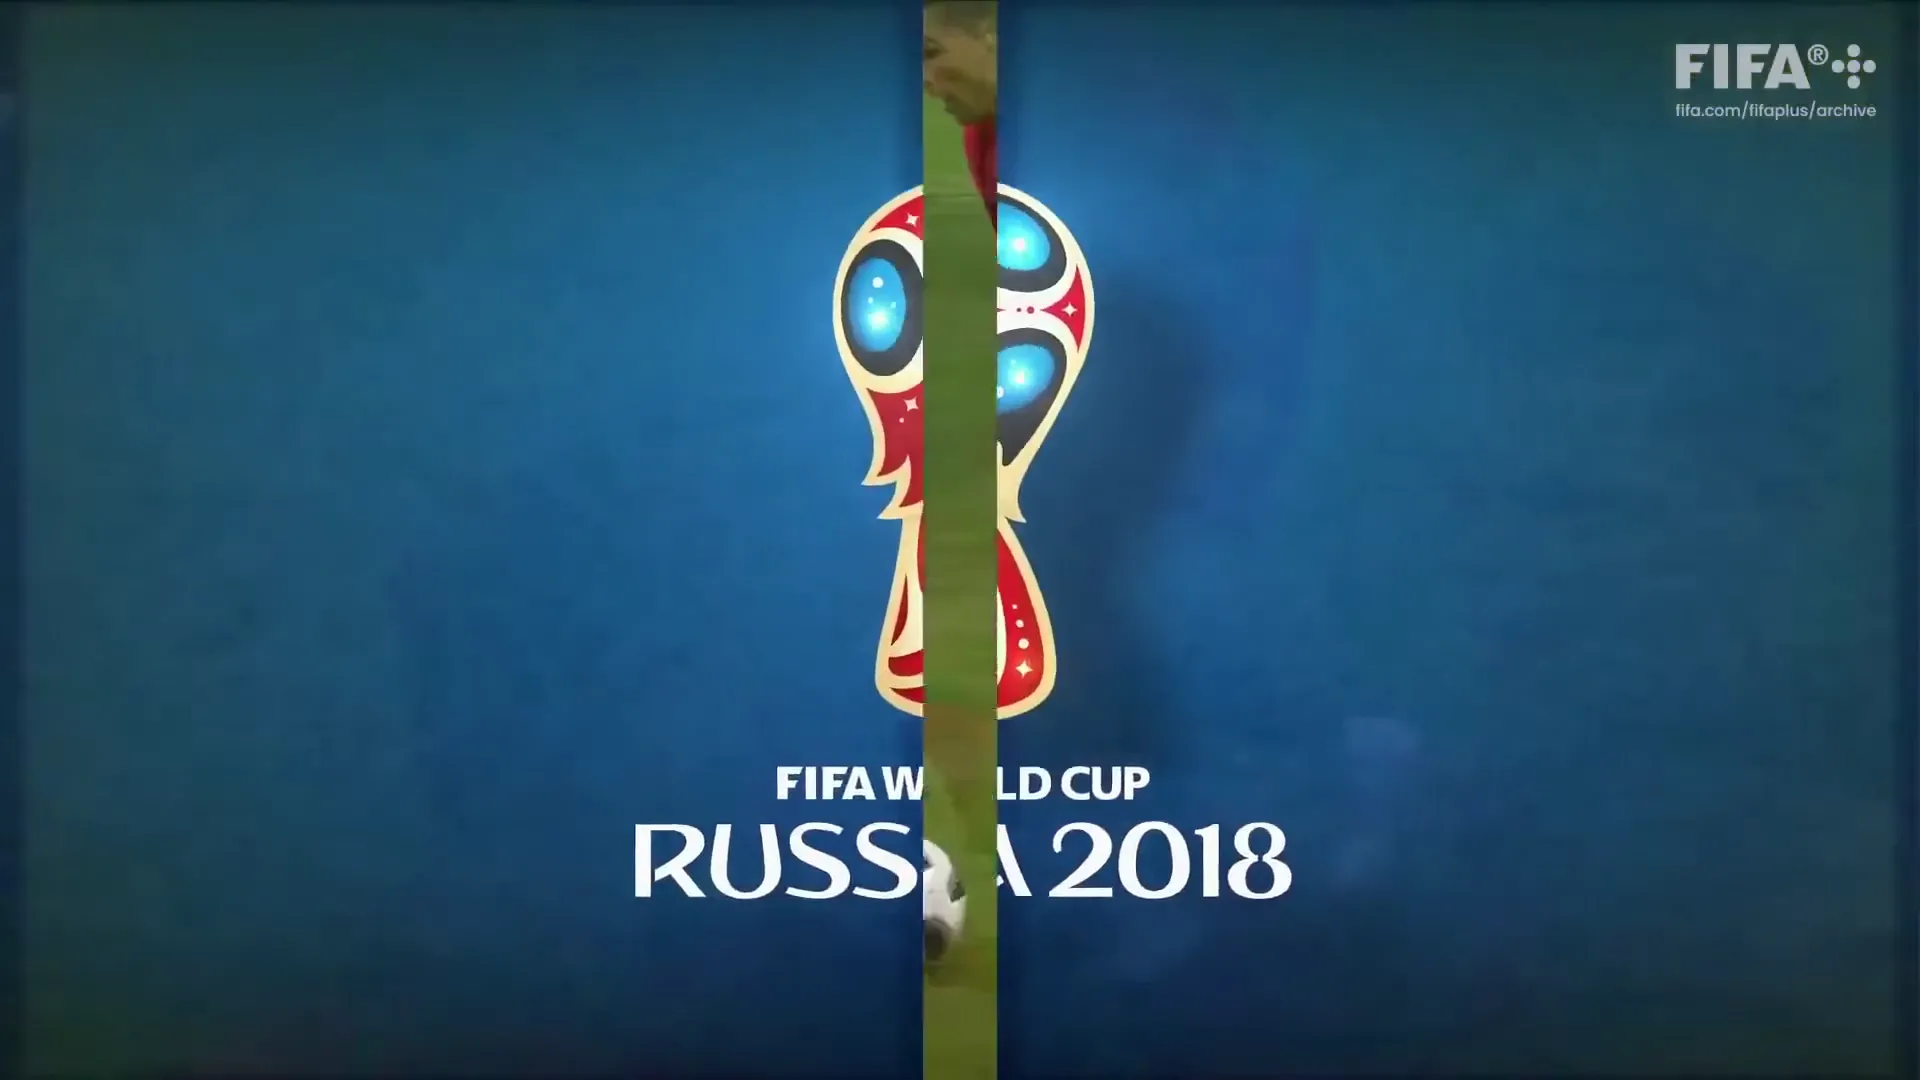
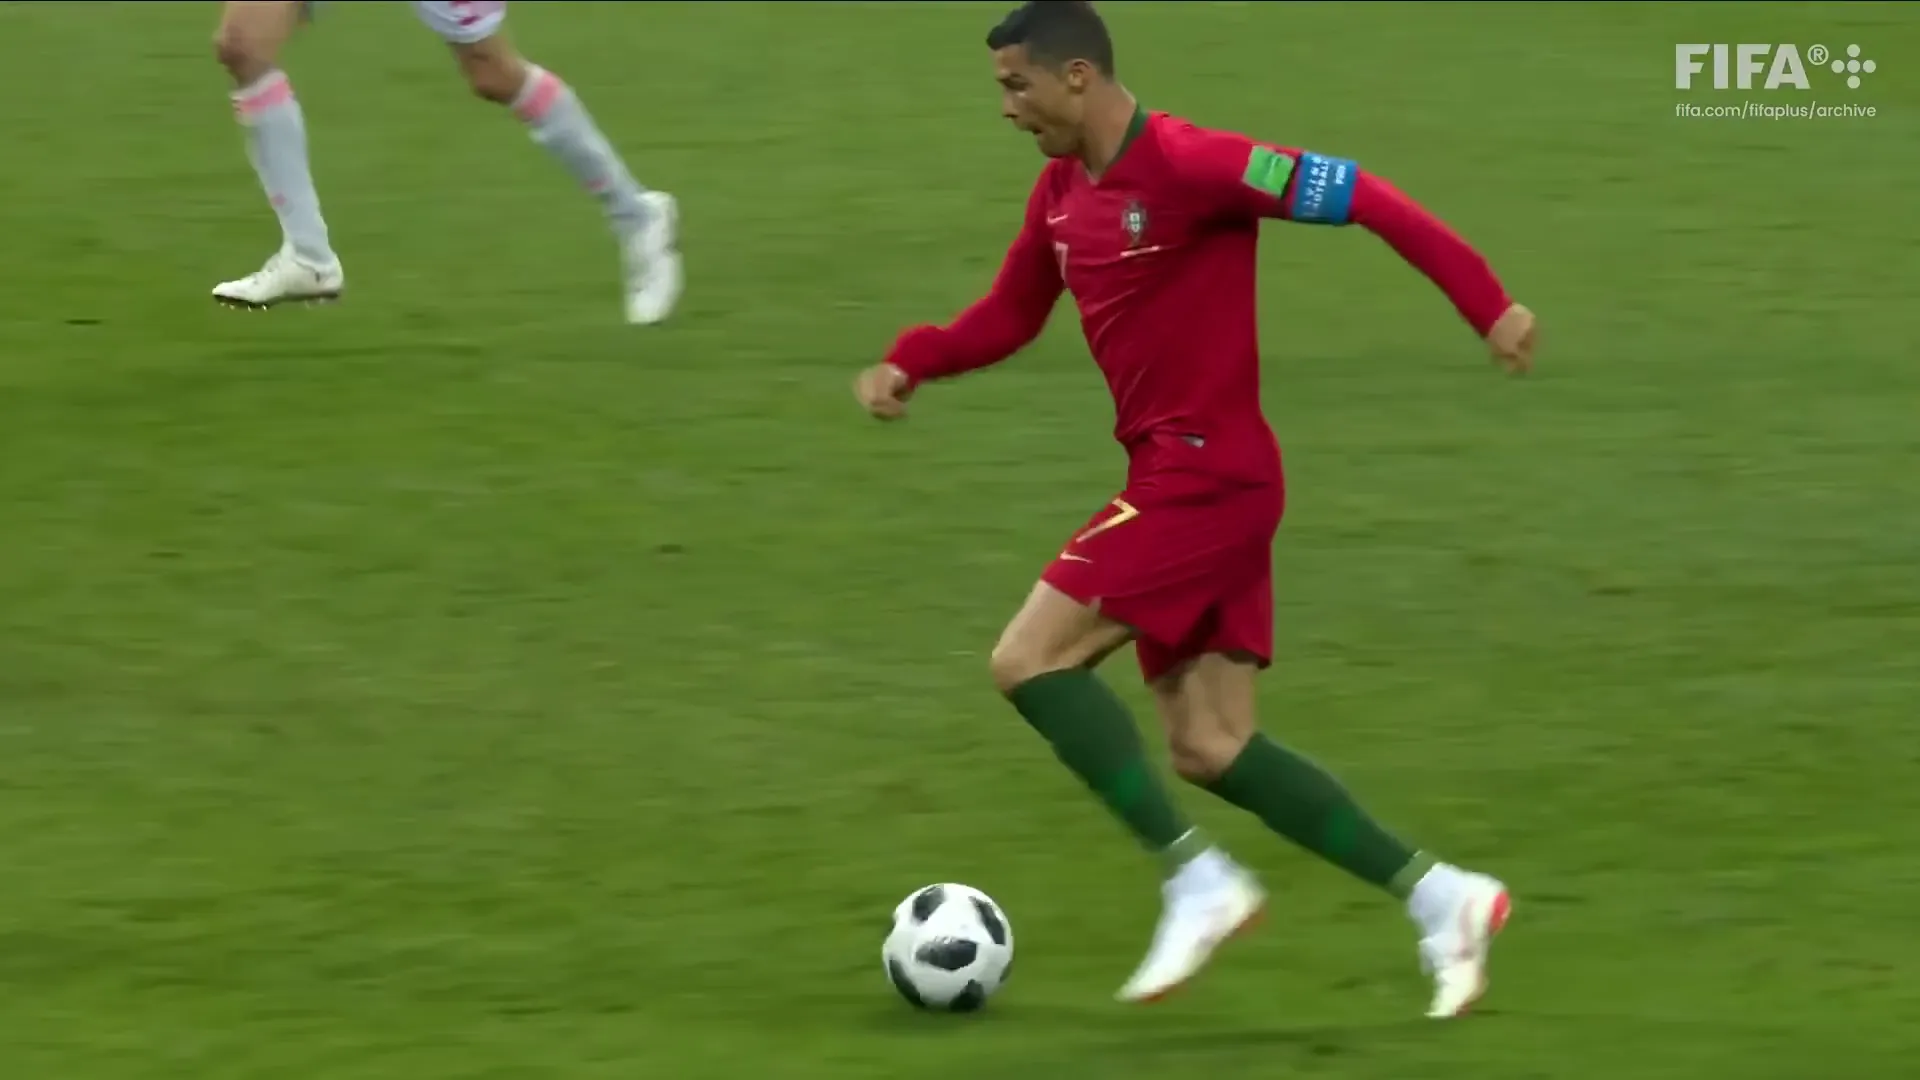
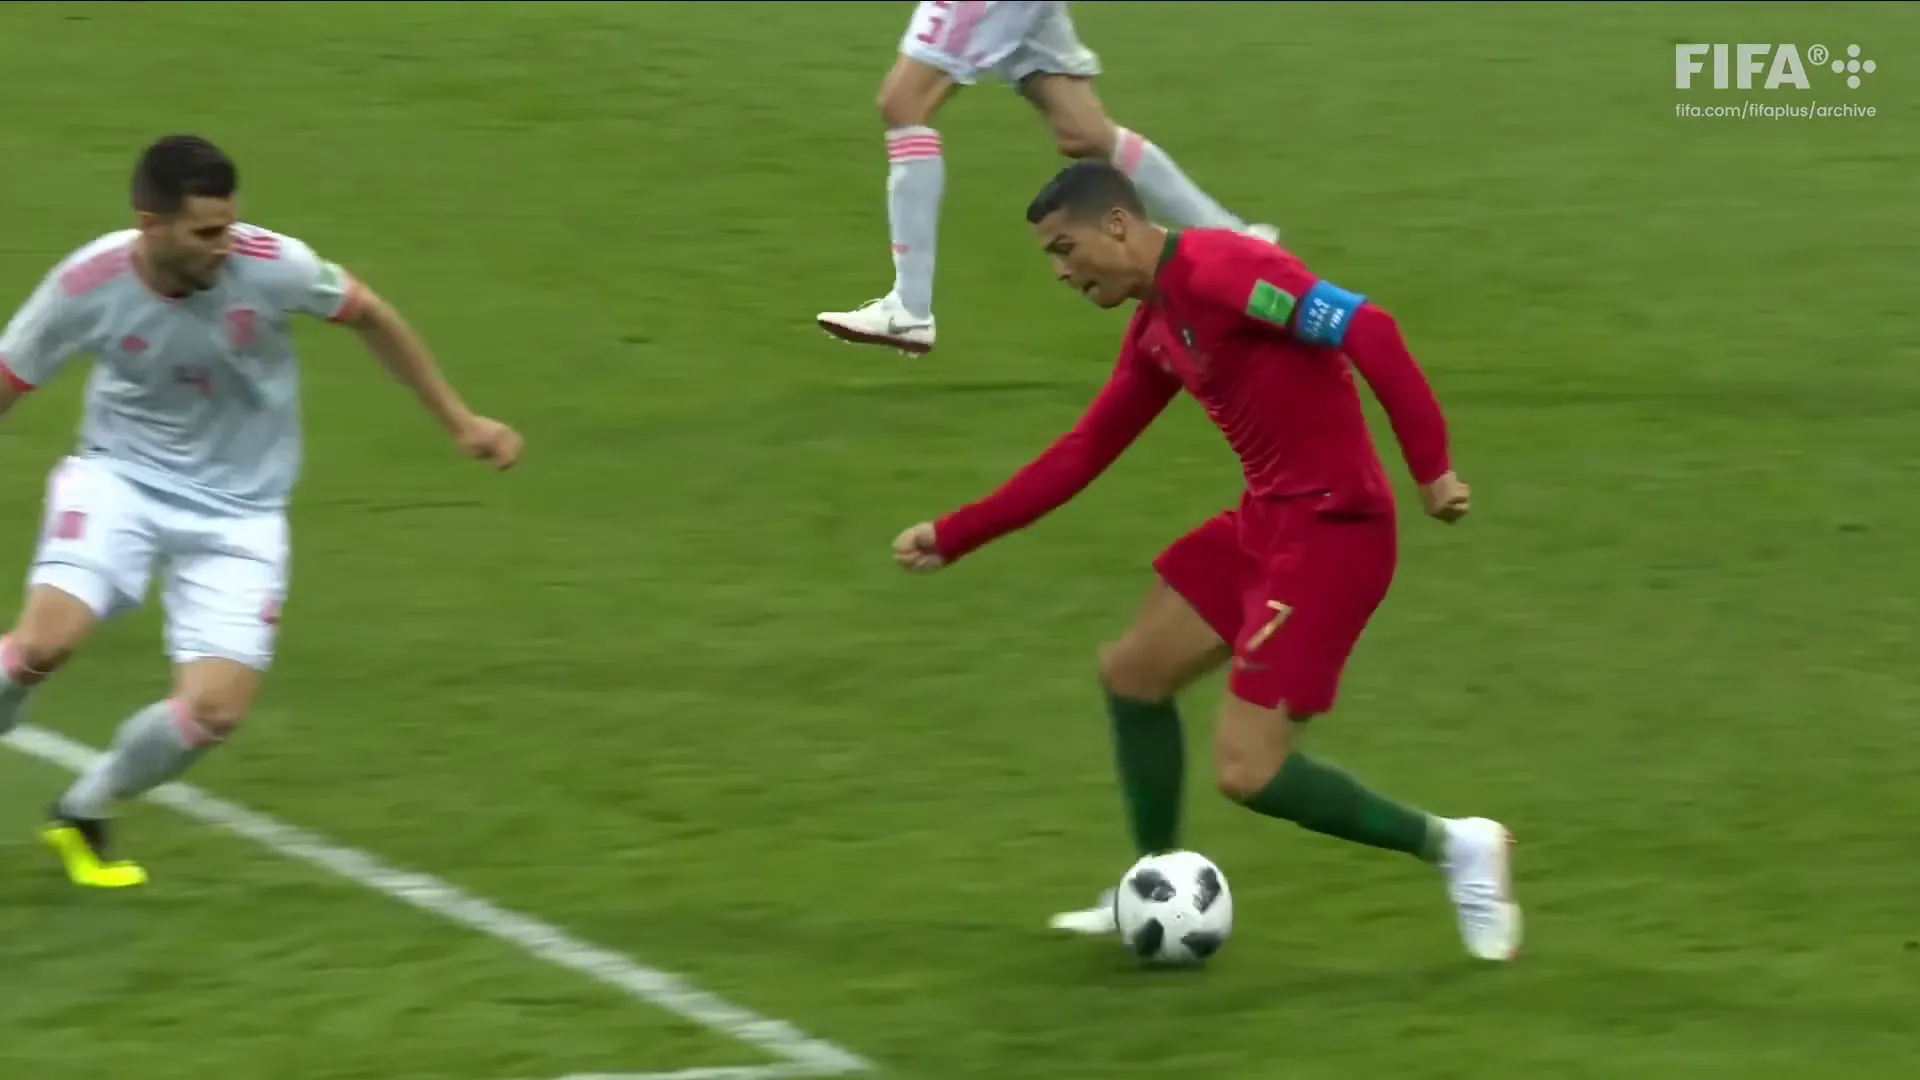
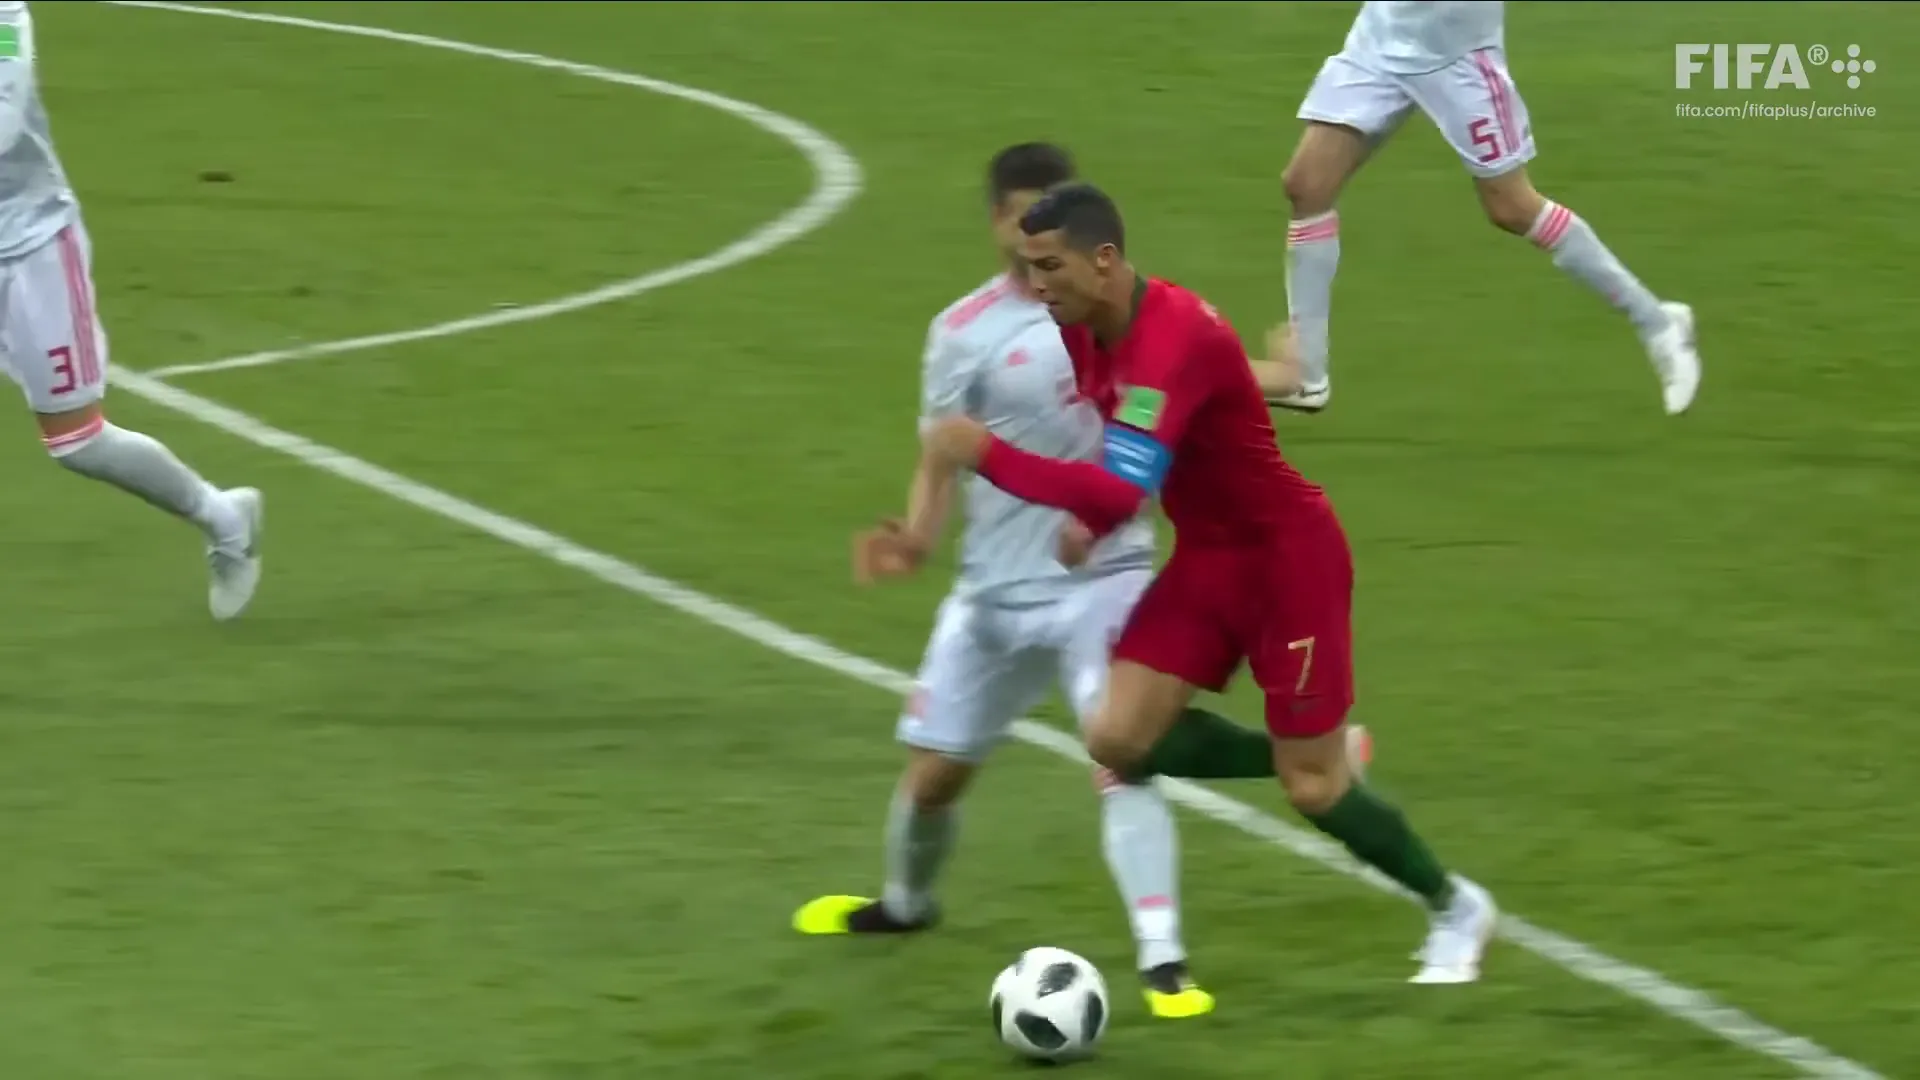
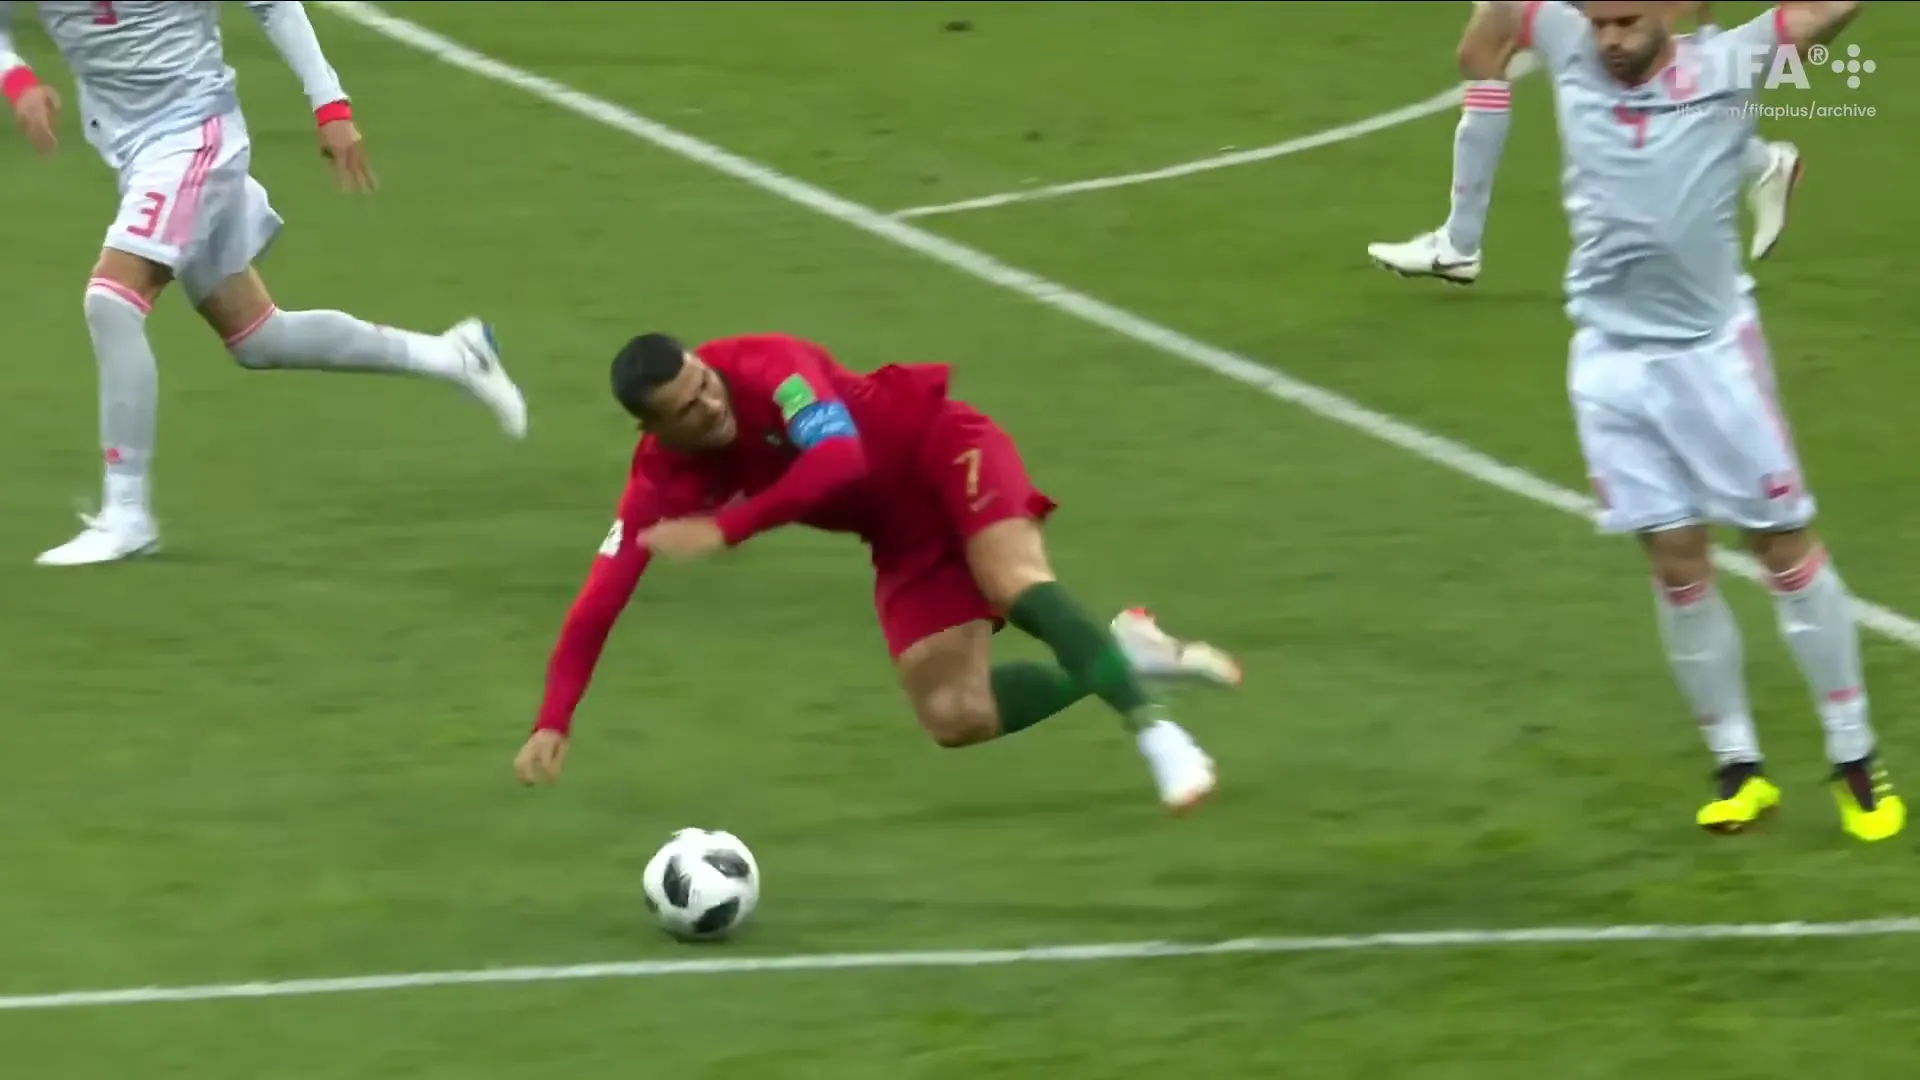
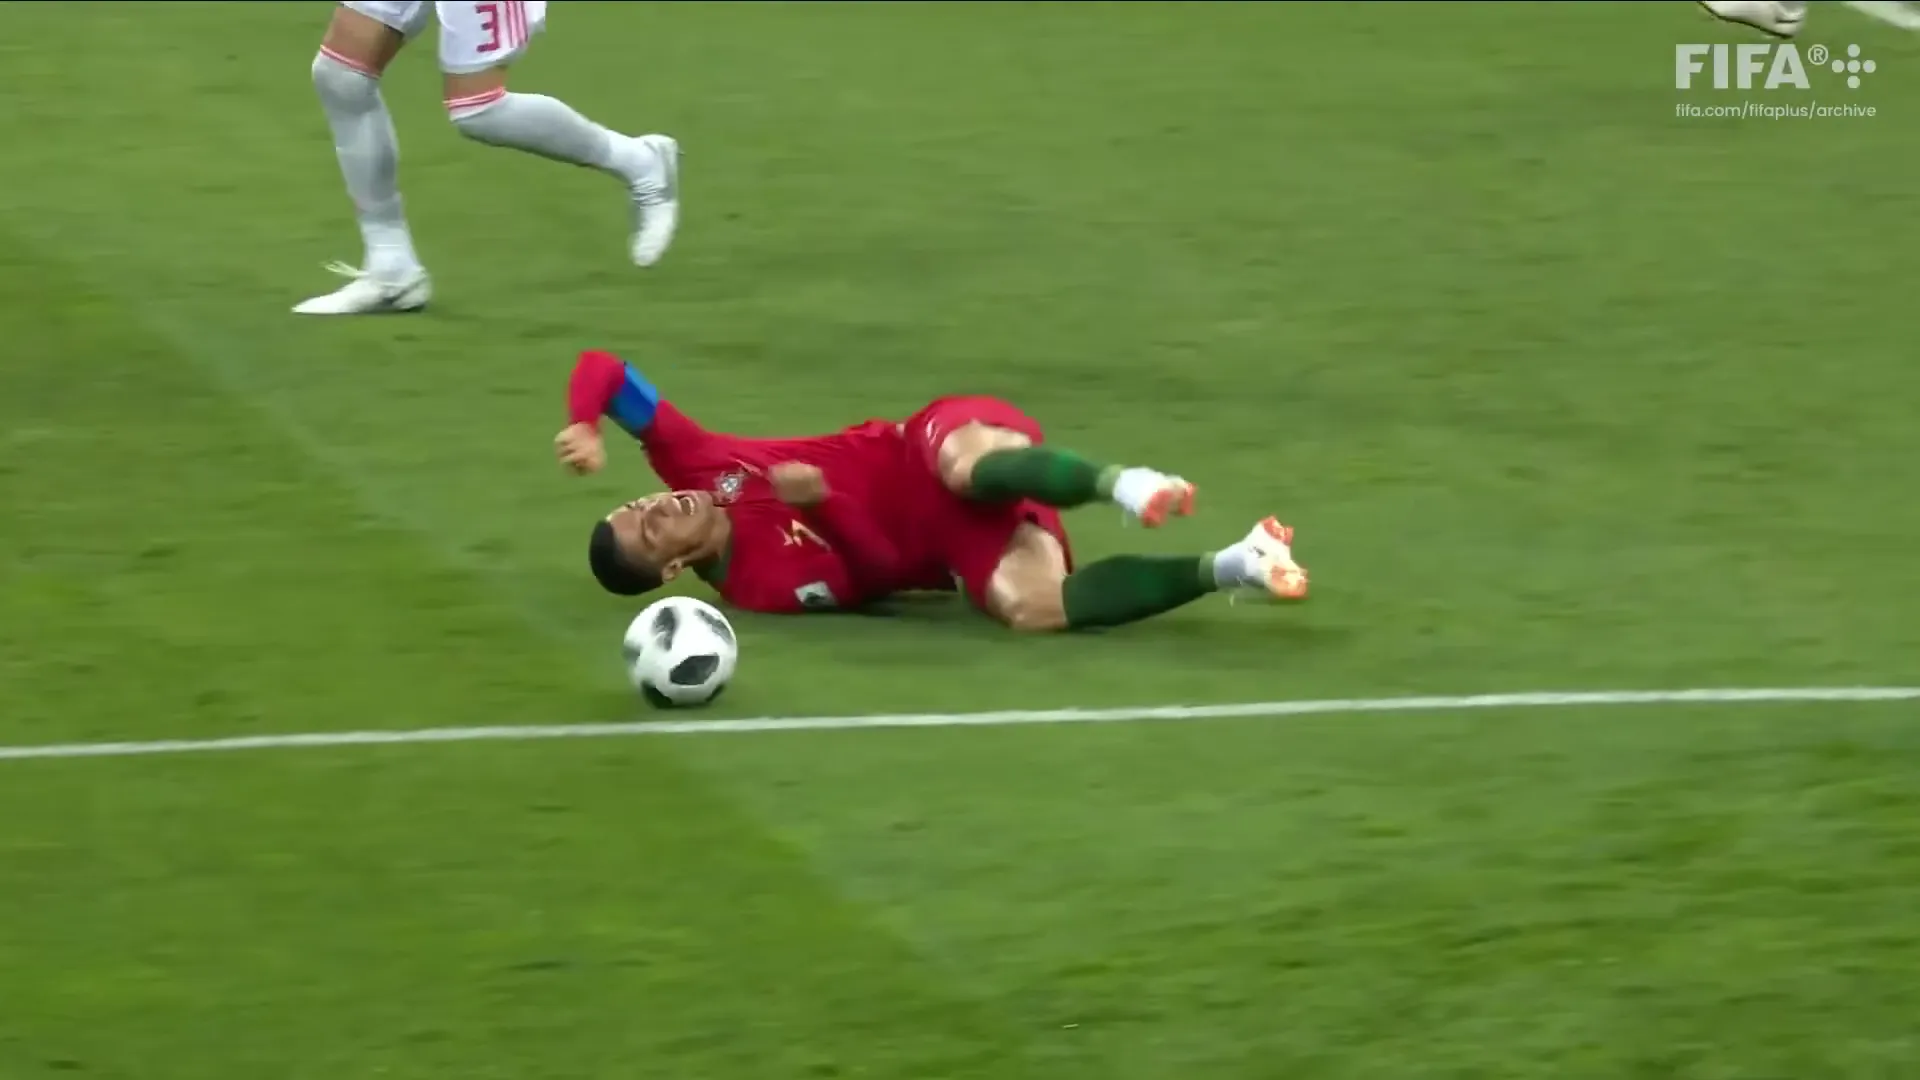
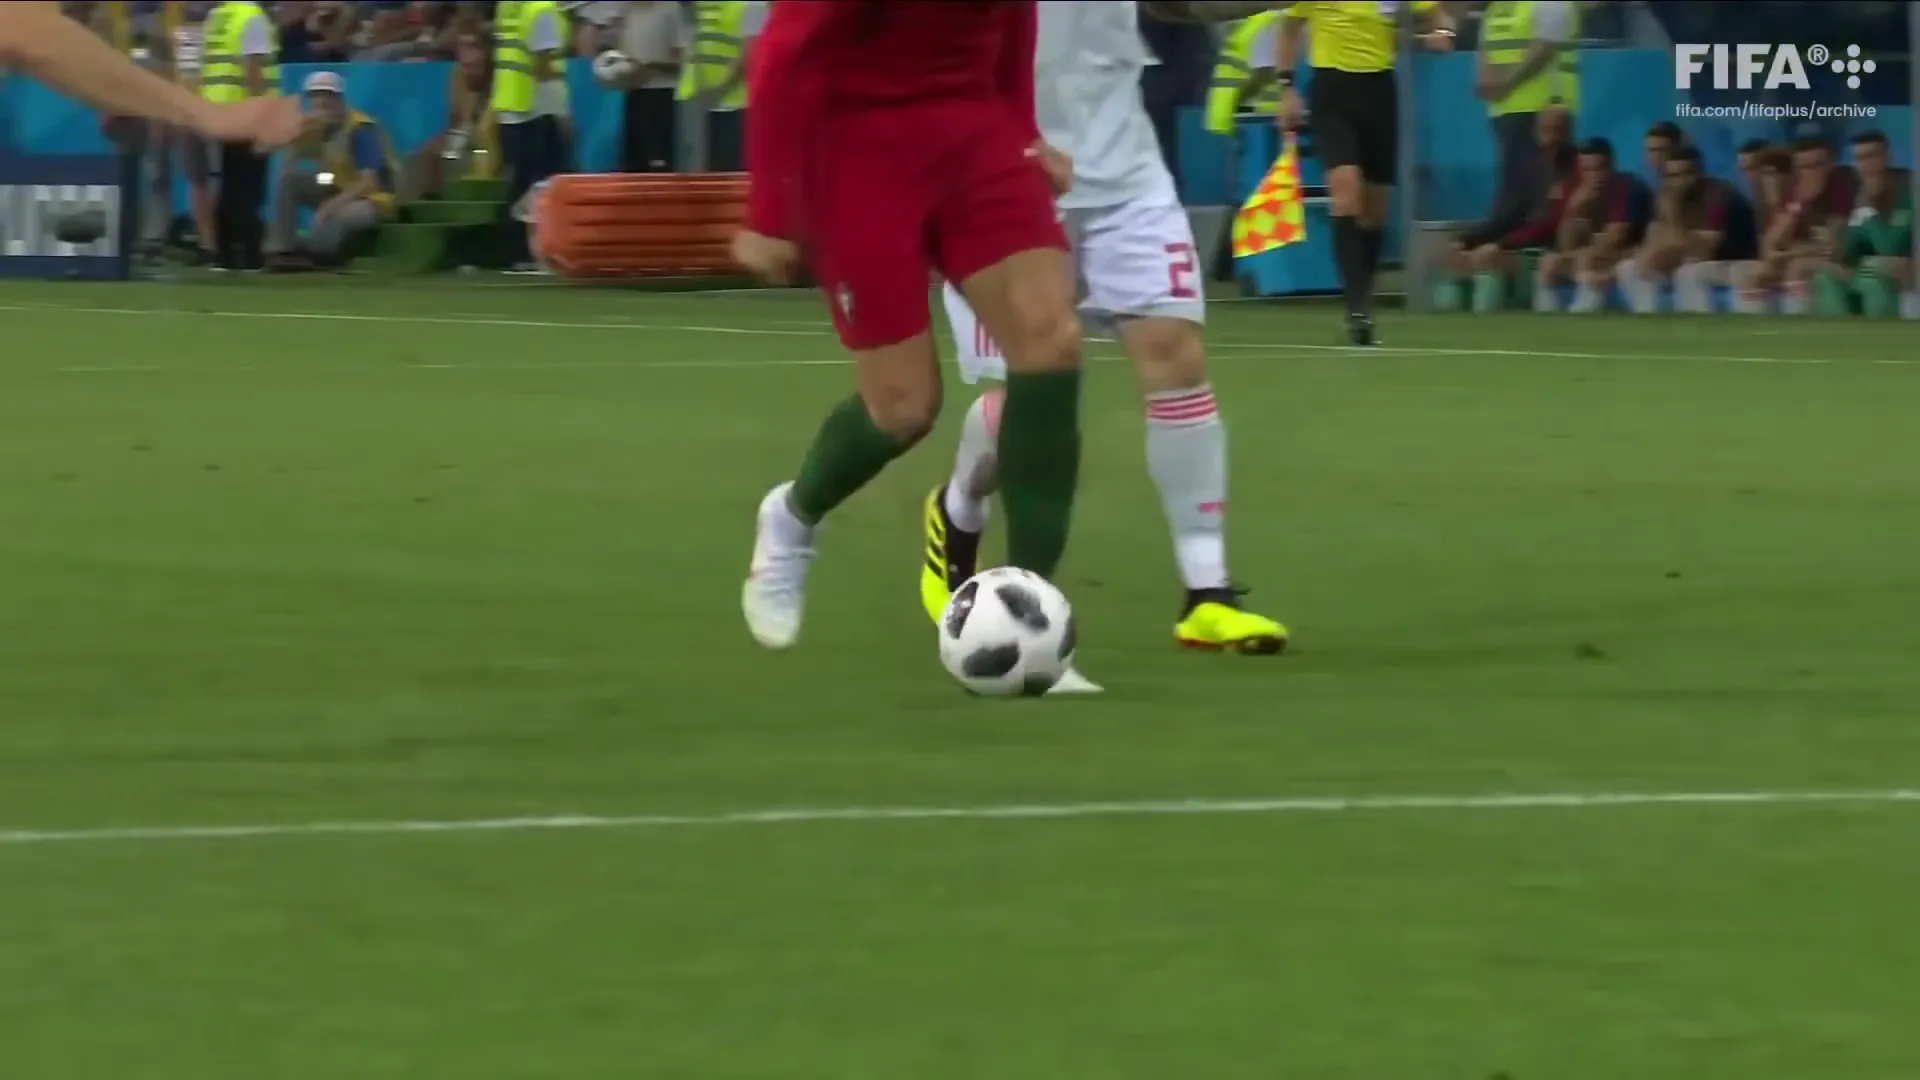

In [26]:
video_frames.select(
    video_frames.frame_idx,
    video_frames.frame,
    video_frames.pos_msec,
).tail(10)

video,audio_extract,video_caption
,,"The video begins with a screen displaying the team lineup for Portugal, featuring players like Ronaldo, Bernardo, and Guedes. The scene then transitions to a wide shot of a soccer field, where players from both teams are lined up for the coin toss. The referee, dressed in yellow, hands the coin to one of the players, who flips it into the air. The players then shake hands as the referee prepares to start the match. Next, the video cuts to a close-up of the referee's hand holding the coin, w ...... ious equipment, including cameras and microphones, which are used to broadcast the game live to viewers around the world. Finally, the video shows a wide shot of the soccer field, with the players from both teams standing on the field. The video ends with a screen displaying the team lineup for Spain, featuring players like David de Gea, Gerard Piqué, and Sergio Busquets. The video concludes by showing the control room once again, with the control room staff continuing to monitor the match."
,,"The video begins with a screen displaying the Spanish national football team's lineup for a match. The screen shows the names of the players, including David de Gea, Gerard Piqué, Nacho, Sergio Busquets, Andrés Iniesta, Koke, Sergio Ramos, Jordi Alba, Diego Costa, David Silva, and Isco. The coach is Fernando Hierro. The lineup is shown in a 4-3-3 formation, with the goalkeeper (David de Gea) positioned as number 1, the defenders (Gerard Piqué and Nacho) as numbers 3 and 4, the midfielders (S ...... quez, Álvaro Odriozola, César Azpilicueta, Nacho Monreal, Iago Aspas, and Marco ASENSIO) as numbers 11, 12, 13, 14, 15, and 16 respectively. The video then cuts to an aerial view of a soccer stadium, showing the field and the stands filled with spectators. The camera then focuses on a man in a suit sitting on the sidelines, looking down at his hands. The man appears to be a coach or a team member, and he is wearing a red pin on his lapel. The camera then cuts to a close-up shot of the man's"
,,"The video captures a moment from a soccer match, specifically a penalty kick scenario during the 2018 FIFA World Cup Russia. The scene is set in a large stadium filled with spectators, creating an atmosphere of anticipation and excitement. Initially, the camera focuses on a player from the white team standing near the penalty spot. He is wearing a white uniform with red accents and the number 19 on his back. His posture suggests he is preparing to take the penalty kick. The ball is position ...... eboard at the bottom of the screen shows the current score as 0-0, indicating that this is the first half of the match. The time displayed is 0:00, suggesting that the penalty kick has just been taken. Throughout the video, the focus remains on the penalty kick and its aftermath, highlighting the intensity and competitive nature of the match. The stadium's vibrant atmosphere and the detailed view of the players' movements provide a comprehensive look at this crucial moment in the World Cup."
,,"The video captures a dynamic moment from a soccer match between Portugal and Spain, as indicated by the scoreboard displaying ""POR 0-0 ESP"" with a timer at 0:37. The scene is set in a large stadium filled with spectators, creating an energetic atmosphere. The players are dressed in their respective team colors; the Portuguese team wears red jerseys, while the Spanish team dons white jerseys. The action begins with a player in a red jersey dribbling the ball down the field. As he moves forwa ...... es a few steps before taking a shot at the goal. The goalkeeper, dressed in green, dives to his left in an attempt to block the shot. However, the player in red successfully scores, as evidenced by the scoreboard updating to ""1-0"" for Spain. The video concludes with the player in red celebrating his goal, while the scoreboard shows the final score of ""1-0"" in favor of Spain. The crowd's excitement is palpable, with fans cheering and waving 
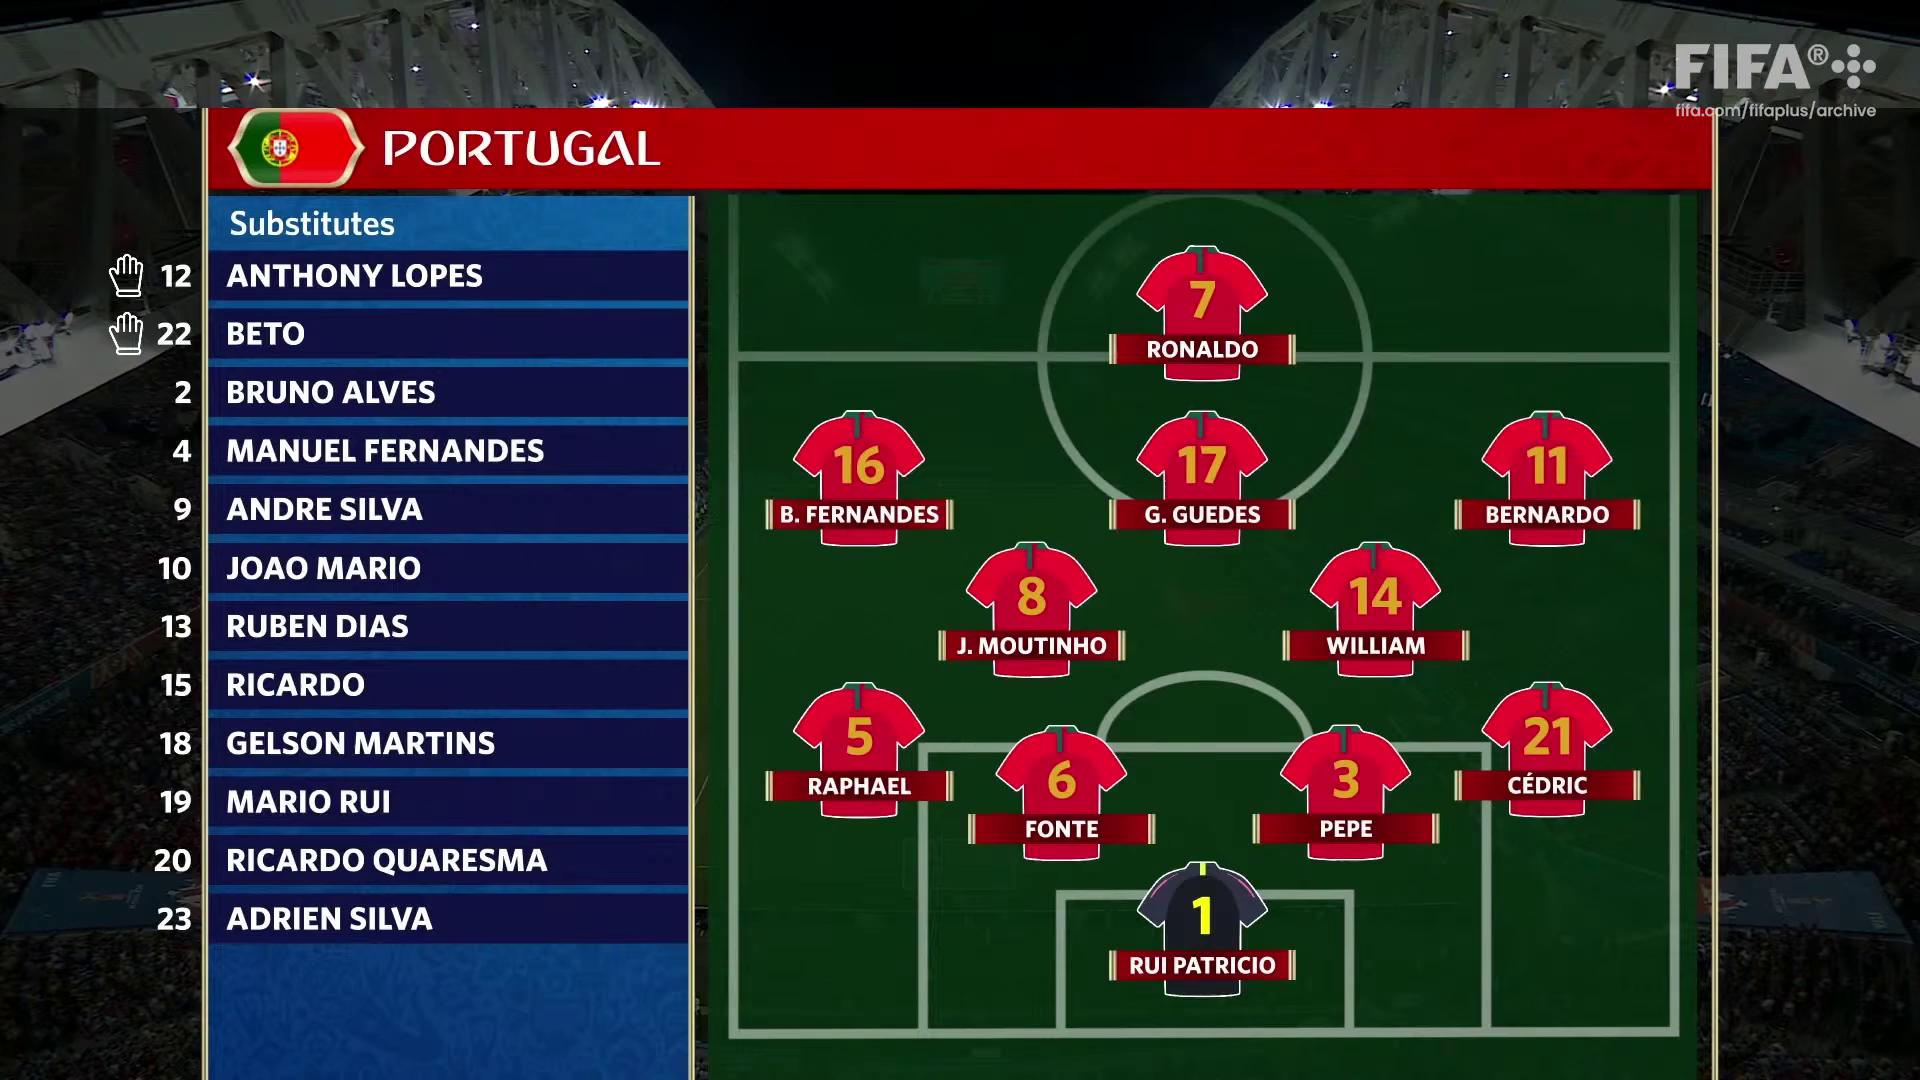
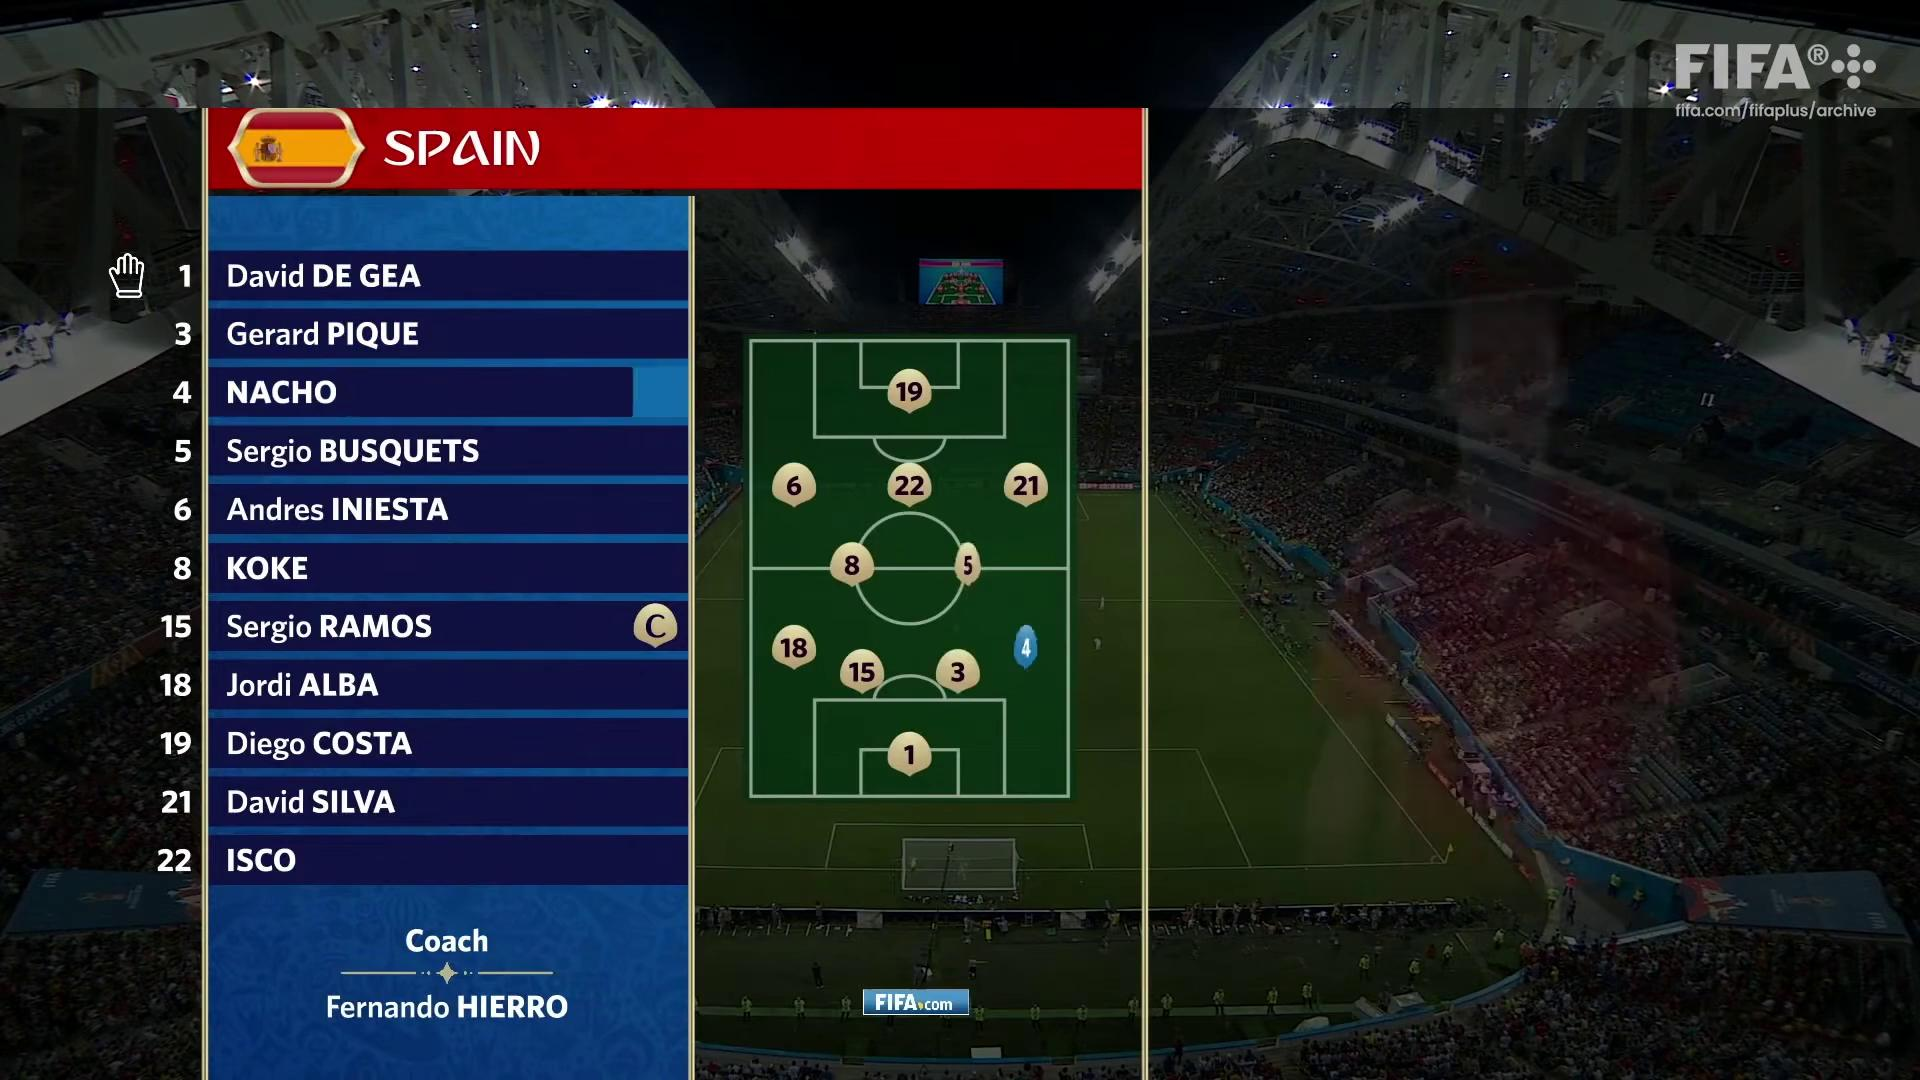
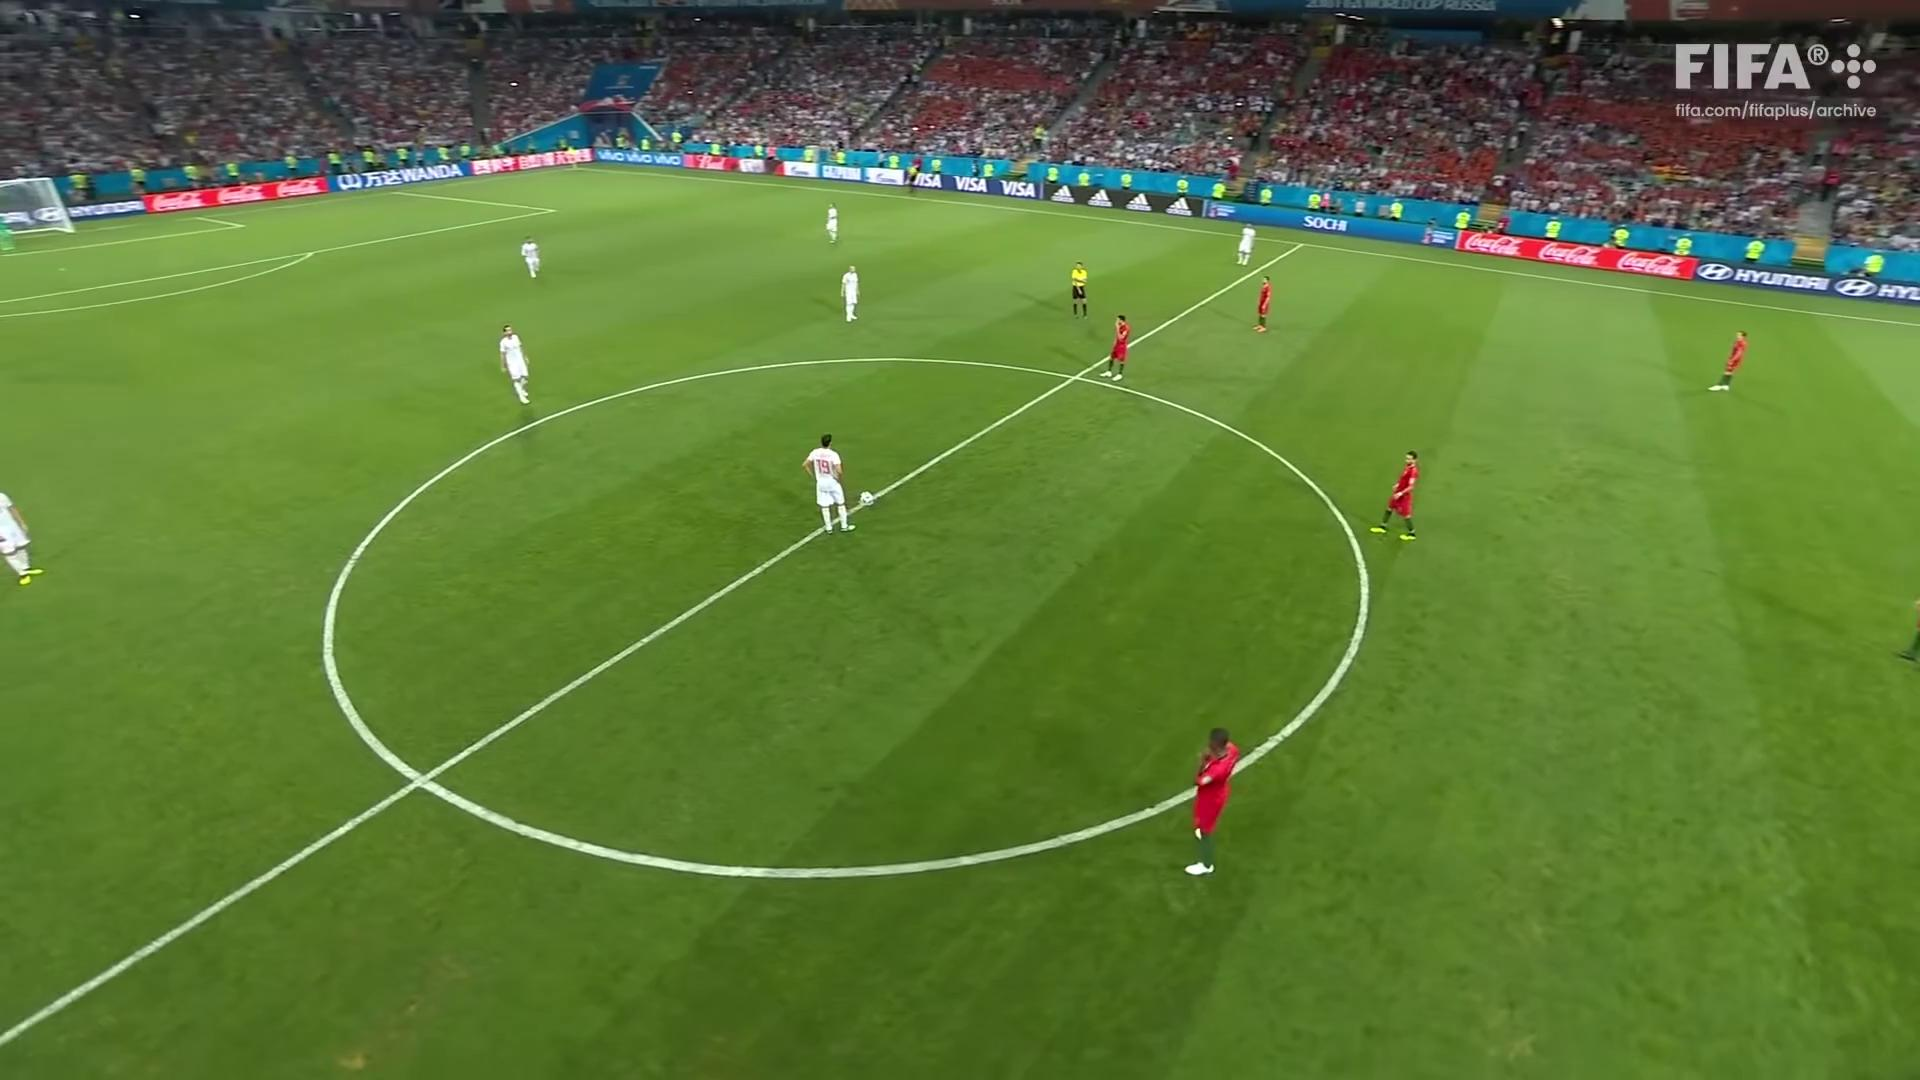
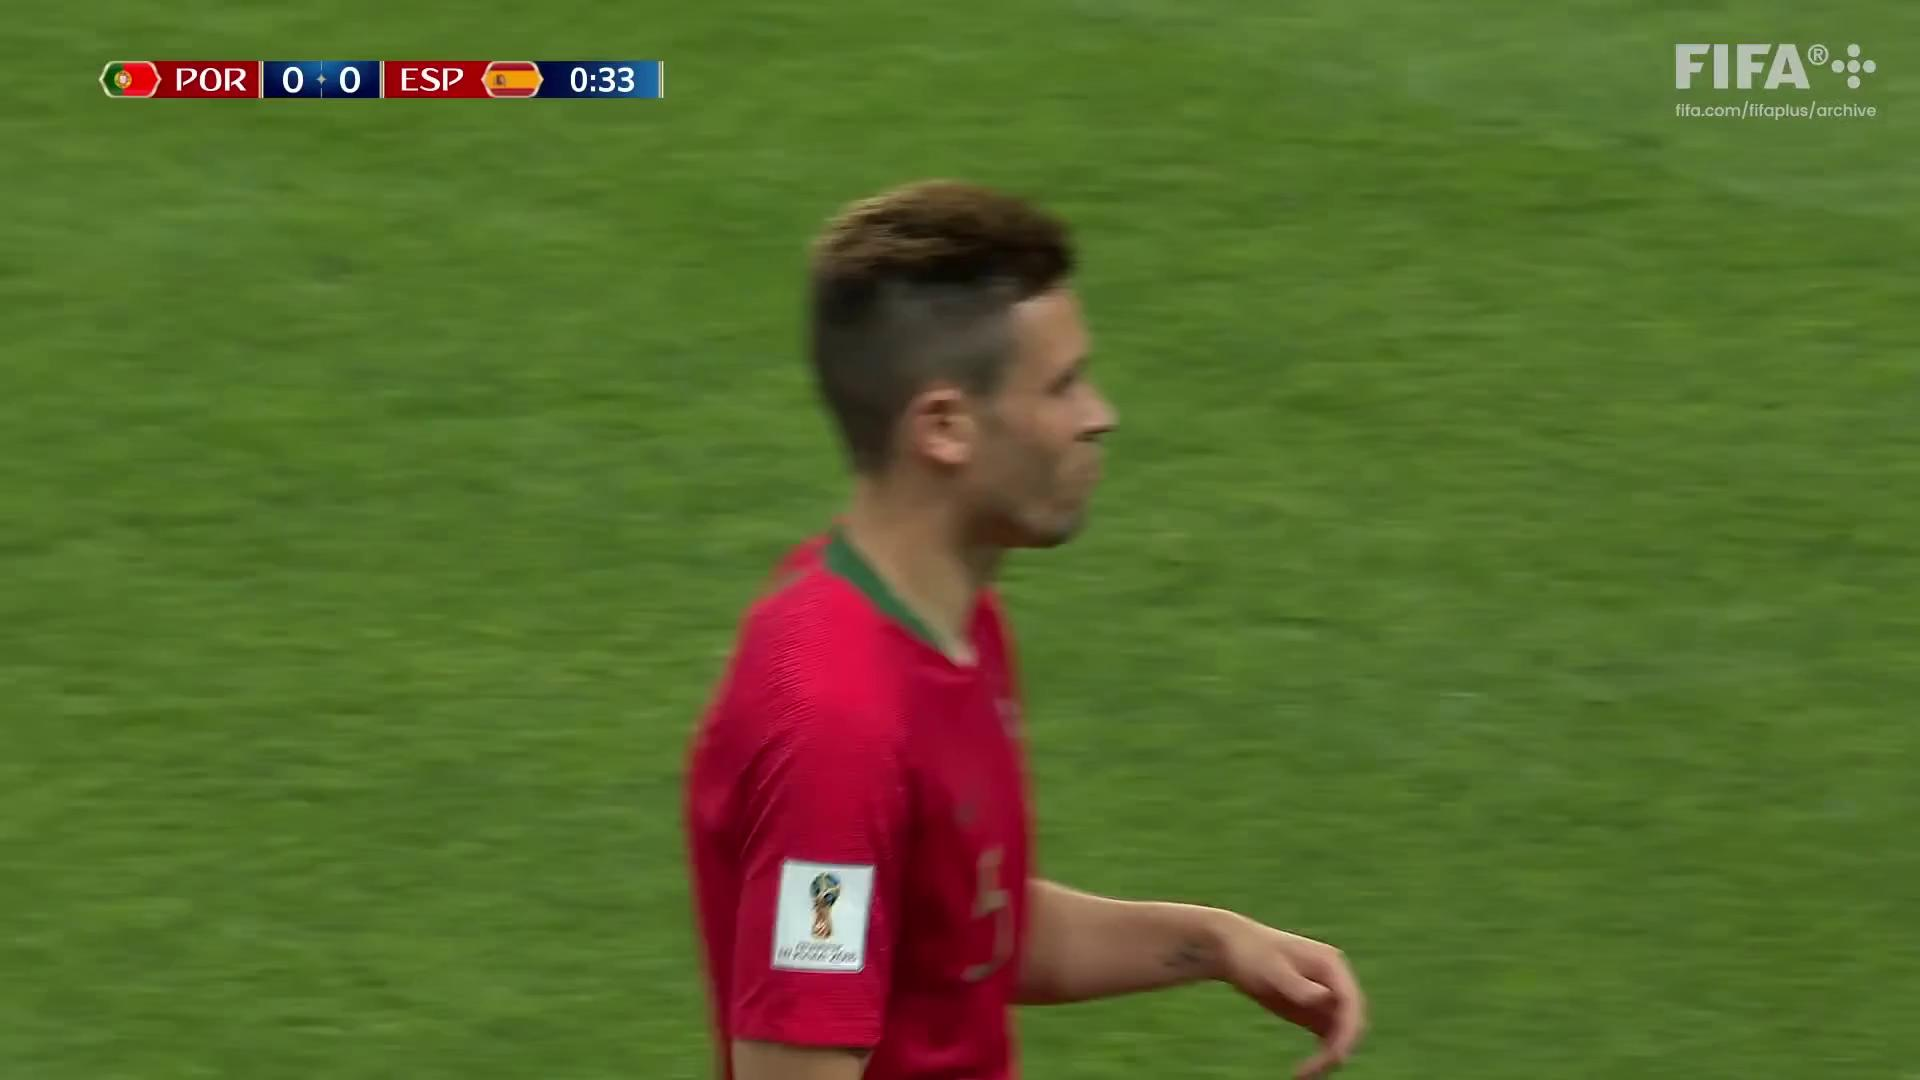
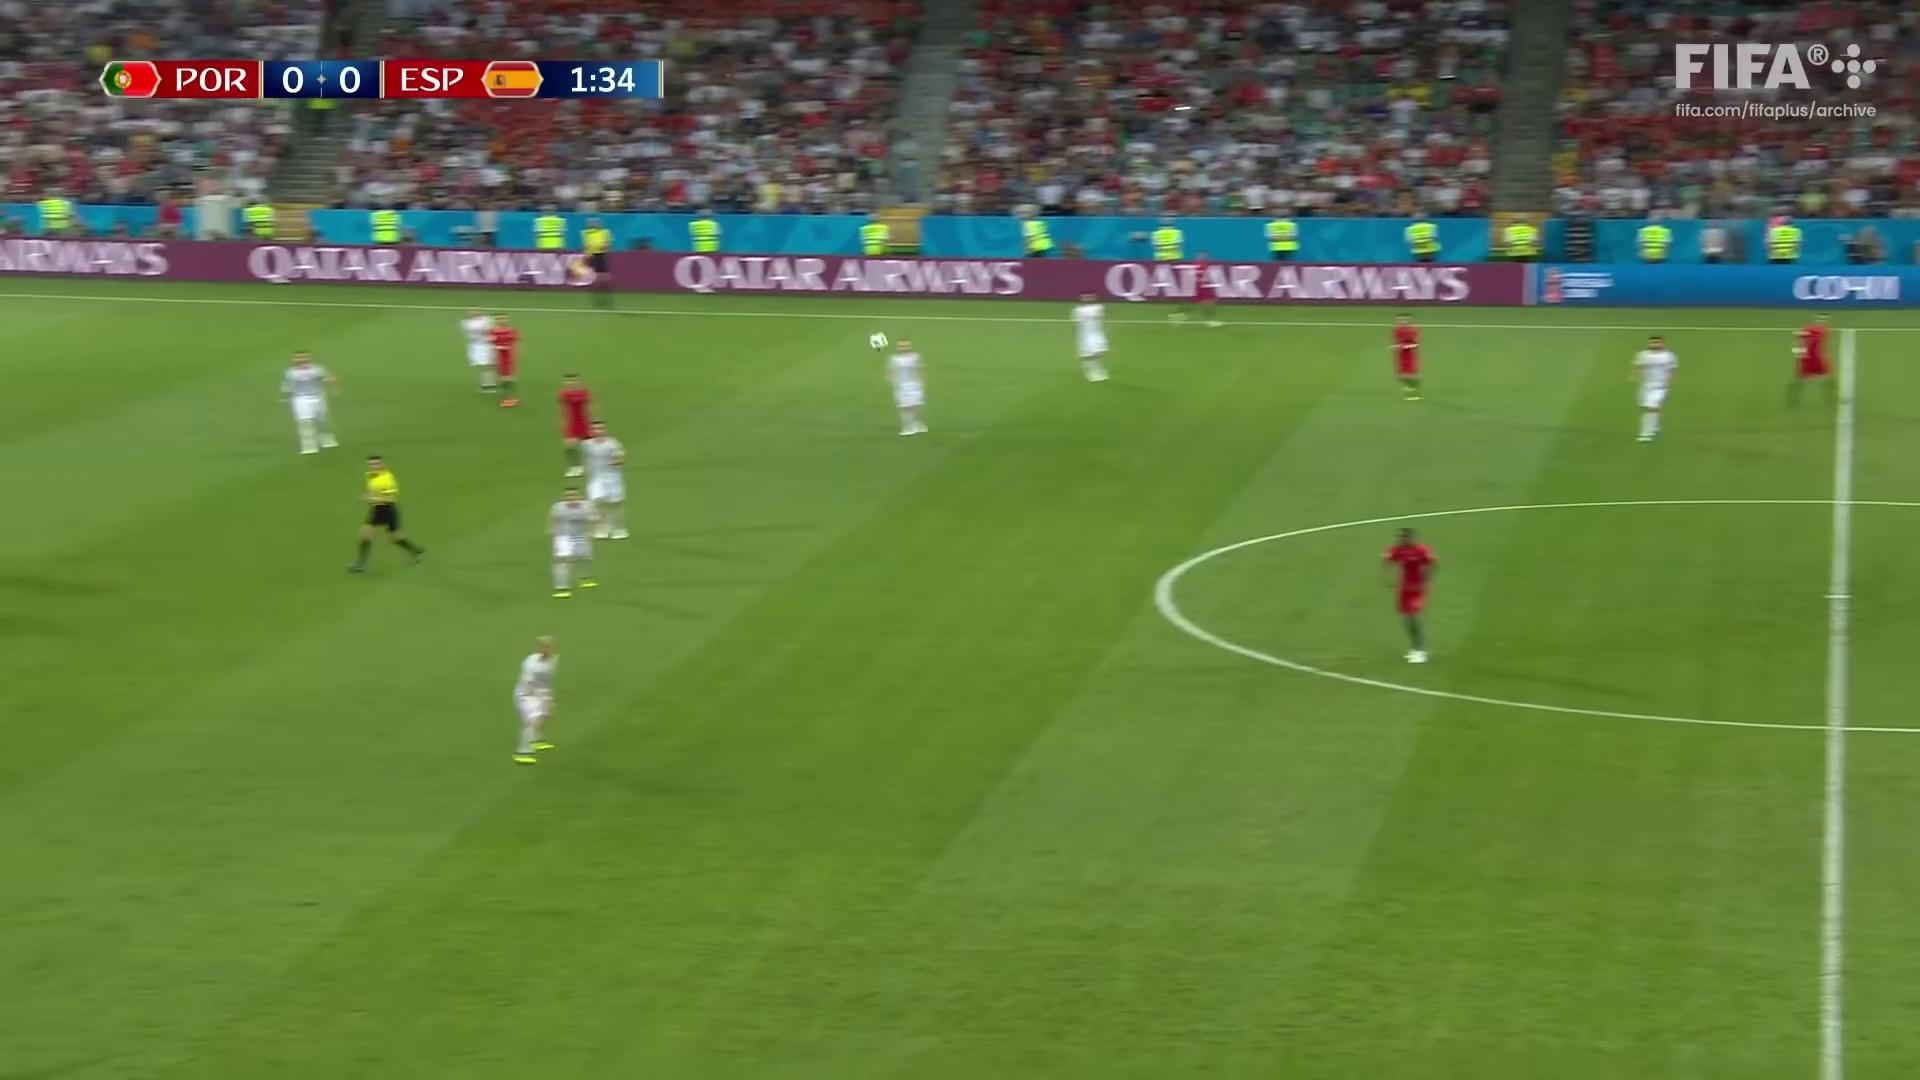

In [27]:
video_table.show()